# Demo PatchTST

Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24237/24237 [05:21<00:00, 75.46it/s]


Epoch 1 Loss: 0.0000


Epoch 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24237/24237 [05:00<00:00, 80.70it/s]


Epoch 2 Loss: 0.0000


Epoch 3: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24237/24237 [04:57<00:00, 81.34it/s]


Epoch 3 Loss: 0.0000


Epoch 4: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24237/24237 [04:59<00:00, 81.03it/s]


Epoch 4 Loss: 0.0000


Epoch 5: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24237/24237 [04:56<00:00, 81.66it/s]


Epoch 5 Loss: 0.0000


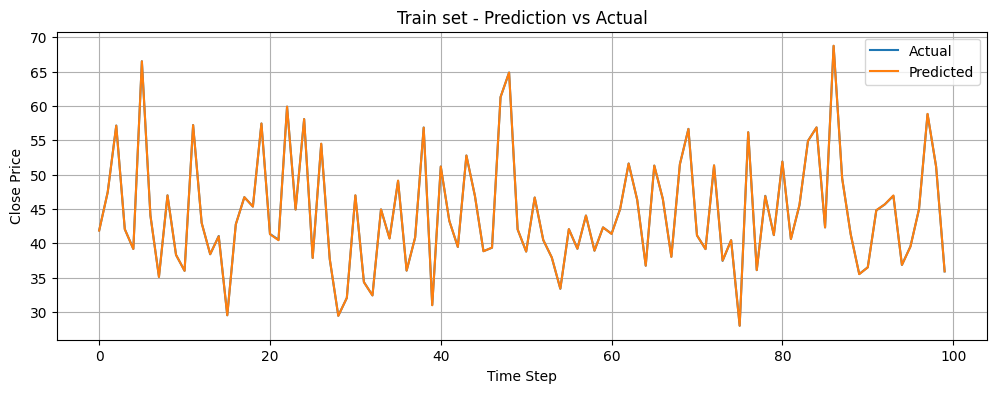

In [ ]:
# --- 1. Th∆∞ vi·ªán ---
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from transformers import PatchTSTConfig, PatchTSTForPrediction
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 2. ƒê·ªçc v√† chu·∫©n h√≥a d·ªØ li·ªáu ---
df = pd.read_parquet('/content/drive/MyDrive/TimeSeries/Data/A-MINUTES1.parquet')
series = df['close'].dropna().values.reshape(-1, 1)

# Chia train/test
train_size = int(0.8 * len(series))
train_series = series[:train_size]
test_series = series[train_size:]

# Chu·∫©n h√≥a ch·ªâ tr√™n train
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_series)
test_scaled = scaler.transform(test_series)

# --- 3. Dataset ---
class TimeSeriesDataset(Dataset):
    def __init__(self, series, context_length, prediction_length):
        self.series = series
        self.context_length = context_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.series) - self.context_length - self.prediction_length

    def __getitem__(self, idx):
        x = self.series[idx : idx + self.context_length]
        y = self.series[idx + self.context_length : idx + self.context_length + self.prediction_length]
        return {
            'past_values': torch.tensor(x, dtype=torch.float),
            'future_values': torch.tensor(y, dtype=torch.float),
        }

context_length = 60
prediction_length = 1  # 1 ph√∫t ti·∫øp theo

train_dataset = TimeSeriesDataset(train_scaled, context_length, prediction_length)
test_dataset = TimeSeriesDataset(test_scaled, context_length, prediction_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- 4. C·∫•u h√¨nh v√† t·∫°o model ---
config = PatchTSTConfig(
    context_length=context_length,
    prediction_length=prediction_length,
    patch_len=10,
    stride=10,
    d_model=64,
    num_layers=2,
    num_heads=2,
    dropout=0.1,
    target_dim=1,
)
model = PatchTSTForPrediction(config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# --- 5. Hu·∫•n luy·ªán ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

for epoch in range(5):  # tƒÉng s·ªë epoch n·∫øu c·∫ßn
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x = batch['past_values'].to(device)
        y = batch['future_values'].to(device)

        outputs = model(past_values=x)
        pred = outputs.prediction_outputs
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# --- 6. H√†m d·ª± ƒëo√°n ---
def predict_and_plot(loader, name="Test"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)
            output = model(past_values=x).prediction_outputs
            preds.append(output.cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    # Inverse scale
    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_inv = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    # V·∫Ω bi·ªÉu ƒë·ªì cho 100 ƒëi·ªÉm ƒë·∫ßu ti√™n
    plt.figure(figsize=(12, 4))
    plt.plot(trues_inv[:100], label='Actual')
    plt.plot(preds_inv[:100], label='Predicted')
    plt.title(f'{name} set - Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 7. Tr·ª±c quan h√≥a ---
predict_and_plot(train_loader, "Train")
predict_and_plot(test_loader, "Test")


# Code theo Logic c·ªßa Vi·ªát (ch∆∞a ch·∫°y)

In [ ]:
# --- 1. Th∆∞ vi·ªán ---
import pandas as pd
import numpy as np
import glob
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PatchTSTConfig, PatchTSTForPrediction
import matplotlib.pyplot as plt
from tqdm import tqdm


# --- 2. LabelEncoder ---
def fit_label_encoder(parquet_folder, save_path="label_encoder.pkl"):
    files = glob.glob(f"{parquet_folder}/*.parquet")
    tickers = sorted({f.split("/")[-1].split("-")[0] for f in files})
    le = LabelEncoder()
    le.fit(tickers)
    with open(save_path, "wb") as f:
        pickle.dump(le, f)
    return le


# --- 3. Ti·ªÅn x·ª≠ l√Ω v√† chu·∫©n h√≥a t·ª´ng ticker ---
def preprocess_data(parquet_folder, label_encoder, missing_threshold=0.8):
    files = glob.glob(f"{parquet_folder}/*.parquet")
    dfs = []
    for f in files:
        ticker = f.split("/")[-1].split("-")[0]
        if ticker not in label_encoder.classes_:
            continue
        df = pd.read_parquet(f).reset_index().rename(columns={"index": "datetime"})
        df["ticker"] = ticker
        dfs.append(df)

    df_all = pd.concat(dfs)
    df_all["datetime"] = pd.to_datetime(df_all["datetime"])
    df_all["date"] = df_all["datetime"].dt.date
    df_all["ticker_id"] = label_encoder.transform(df_all["ticker"])

    # Chu·∫©n h√≥a t·ª´ng ticker ri√™ng
    scalers = {}
    df_all["scaled_close"] = np.nan
    for ticker in df_all["ticker"].unique():
        mask = df_all["ticker"] == ticker
        scaler = StandardScaler()
        df_all.loc[mask, "scaled_close"] = scaler.fit_transform(df_all.loc[mask, ["close"]])
        scalers[ticker] = scaler

    df_all["close"] = df_all["scaled_close"]
    return df_all.drop(columns=["scaled_close"]), scalers


# --- 4. T·∫°o sequence ---
def create_sequences(df, window=60):
    X, y, tid = [], [], []
    for ticker_id in df["ticker_id"].unique():
        temp = df[df["ticker_id"] == ticker_id].sort_values("datetime")
        close_vals = temp["close"].values
        for i in range(len(close_vals) - window):
            X.append(close_vals[i:i+window])
            y.append(close_vals[i+window])
            tid.append(ticker_id)
    return np.array(X), np.array(y), np.array(tid)


# --- 5. Chia train/val/test theo th·ªùi gian ---
def split_timewise(X, y, tid, val_ratio=0.2, test_ratio=0.2):
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    tid_train, tid_val, tid_test = [], [], []

    for t in np.unique(tid):
        idx = np.where(tid == t)[0]
        if len(idx) < 10: continue
        n_test = int(len(idx) * test_ratio)
        n_val = int((len(idx) - n_test) * val_ratio)

        X_t, y_t = X[idx], y[idx]
        t_t = tid[idx]

        X_train.append(X_t[:-n_test-n_val])
        y_train.append(y_t[:-n_test-n_val])
        tid_train.append(t_t[:-n_test-n_val])

        X_val.append(X_t[-n_test-n_val:-n_test])
        y_val.append(y_t[-n_test-n_val:-n_test])
        tid_val.append(t_t[-n_test-n_val:-n_test])

        X_test.append(X_t[-n_test:])
        y_test.append(y_t[-n_test:])
        tid_test.append(t_t[-n_test:])

    return map(torch.tensor, [np.concatenate(X_train), np.concatenate(X_val), np.concatenate(X_test),
                              np.concatenate(y_train), np.concatenate(y_val), np.concatenate(y_test),
                              np.concatenate(tid_train), np.concatenate(tid_val), np.concatenate(tid_test)])


# --- 6. Dataset PyTorch ---
class MultiTickerDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.float().unsqueeze(-1)  # [N, 60, 1] => th√™m chi·ªÅu ƒë·∫∑c tr∆∞ng
        self.y = y.float().unsqueeze(-1)  # [N, 1]

    def __len__(self): return len(self.x)

    def __getitem__(self, idx):
        return {
            "past_values": self.x[idx],   # shape: [60, 1]
            "future_values": self.y[idx], # shape: [1]
        }



# --- 7. Hu·∫•n luy·ªán ---
def train_model(model, train_loader, epochs=5, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)

            out = model(past_values=x).prediction_outputs
            loss = loss_fn(out, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


# --- 8. D·ª± ƒëo√°n v√† bi·ªÉu ƒë·ªì ---
def predict_plot(model, loader, scaler, name="Test"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)
            out = model(past_values=x).prediction_outputs
            preds.append(out.cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_inv = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    plt.figure(figsize=(12, 4))
    plt.plot(trues_inv[:100], label='Actual')
    plt.plot(preds_inv[:100], label='Predicted')
    plt.title(f"{name} - Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()


# --- 9. Main ch·∫°y th·ª≠ ---
# Load encoder
label_encoder = fit_label_encoder("/content/drive/MyDrive/Draft/TimeSeries/Data")
df_all, scalers = preprocess_data("/content/drive/MyDrive/Draft/TimeSeries/Demo_Data_5", label_encoder)

X, y, tid = create_sequences(df_all, window=60)
X_train, X_val, X_test, y_train, y_val, y_test, _, _, _ = split_timewise(X, y, tid)

train_loader = DataLoader(MultiTickerDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(MultiTickerDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(MultiTickerDataset(X_test, y_test), batch_size=64)

config = PatchTSTConfig(
    context_length=60,
    prediction_length=1,
    patch_len=10,
    stride=10,
    d_model=64,
    num_layers=2,
    num_heads=2,
    dropout=0.1,
    target_dim=1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchTSTForPrediction(config).to(device)

train_model(model, train_loader, epochs=5)
predict_plot(model, test_loader, list(scalers.values())[0], "Test")


Epoch 1:   0%|          | 0/50127 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1:  39%|‚ñà‚ñà‚ñà‚ñâ      | 19718/50127 [03:49<05:53, 85.98it/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
df = pd.read_parquet("/content/drive/MyDrive/Draft/TimeSeries/Demo_Data_5/AMZN-MINUTES1.parquet")
df

open     high      low     close    vol
2010-01-04 17:30:00   136.1500   136.40   135.76   135.870  61657
2010-01-04 17:31:00   135.9399   136.07   135.75   135.770  68212
2010-01-04 17:32:00   135.8680   135.88   135.40   135.400  44408
2010-01-04 17:33:00   135.4050   135.63   135.32   135.320  75774
2010-01-04 17:34:00   135.3400   135.51   135.34   135.385  33723
...                        ...      ...      ...       ...    ...
2020-11-25 23:46:00  3189.3100  3189.31  3189.31  3189.310    100
2020-11-25 23:47:00  3189.1200  3189.74  3189.12  3189.740    300
2020-11-25 23:48:00  3187.3350  3187.34  3185.00  3185.000    300
2020-11-25 23:49:00  3184.7600  3184.98  3184.76  3184.980    300
2020-11-25 23:50:00  3185.0800  3185.08  3185.08  3185.080    103

[980624 rows x 5 columns]

Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24236/24236 [04:39<00:00, 86.73it/s]


Epoch 1 Loss: 0.0003


Epoch 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24236/24236 [04:39<00:00, 86.71it/s]


Epoch 2 Loss: 0.0003


Epoch 3: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24236/24236 [04:37<00:00, 87.35it/s]


Epoch 3 Loss: 0.0003


Epoch 4: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24236/24236 [04:36<00:00, 87.62it/s]


Epoch 4 Loss: 0.0003


Epoch 5: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24236/24236 [05:02<00:00, 80.05it/s]


Epoch 5 Loss: 0.0003


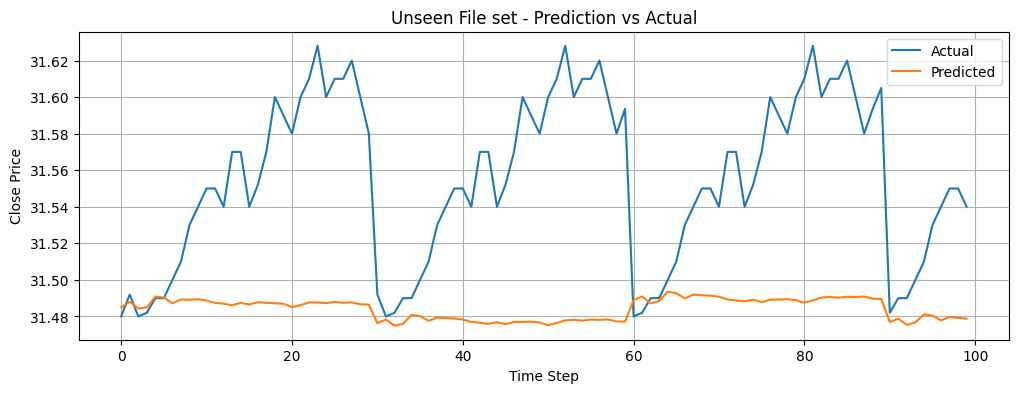

In [ ]:
# --- 1. Th∆∞ vi·ªán ---
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from transformers import PatchTSTConfig, PatchTSTForPrediction
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 2. ƒê·ªçc v√† chu·∫©n h√≥a d·ªØ li·ªáu hu·∫•n luy·ªán ---
df = pd.read_parquet('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet')
series = df['close'].dropna().values.reshape(-1, 1)

# Chia train/test
train_size = int(0.8 * len(series))
train_series = series[:train_size]
test_series = series[train_size:]

# Chu·∫©n h√≥a ch·ªâ tr√™n train
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_series)
test_scaled = scaler.transform(test_series)

# --- 3. Dataset ---
class TimeSeriesDataset(Dataset):
    def __init__(self, series, context_length, prediction_length):
        self.series = series
        self.context_length = context_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.series) - self.context_length - self.prediction_length

    def __getitem__(self, idx):
        x = self.series[idx : idx + self.context_length]
        y = self.series[idx + self.context_length : idx + self.context_length + self.prediction_length]
        return {
            'past_values': torch.tensor(x, dtype=torch.float),
            'future_values': torch.tensor(y, dtype=torch.float),
        }

context_length = 60
prediction_length = 30

train_dataset = TimeSeriesDataset(train_scaled, context_length, prediction_length)
test_dataset = TimeSeriesDataset(test_scaled, context_length, prediction_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- 4. C·∫•u h√¨nh v√† t·∫°o model ---
config = PatchTSTConfig(
    context_length=context_length,
    prediction_length=prediction_length,
    patch_len=10,
    stride=10,
    d_model=64,
    num_layers=2,
    num_heads=2,
    dropout=0.1,
    target_dim=1,
)
model = PatchTSTForPrediction(config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# --- 5. Hu·∫•n luy·ªán ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x = batch['past_values'].to(device)
        y = batch['future_values'].to(device)

        outputs = model(past_values=x)
        pred = outputs.prediction_outputs
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# --- 6. H√†m d·ª± ƒëo√°n ---
def predict_and_plot(loader, name="Test"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)
            output = model(past_values=x).prediction_outputs
            preds.append(output.cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_inv = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    plt.figure(figsize=(12, 4))
    plt.plot(trues_inv[:100], label='Actual')
    plt.plot(preds_inv[:100], label='Predicted')
    plt.title(f'{name} set - Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 7. Tr·ª±c quan h√≥a ---
predict_and_plot(train_loader, "Train")
predict_and_plot(test_loader, "Test")

# --- 8. D·ª± ƒëo√°n tr√™n file ch∆∞a hu·∫•n luy·ªán ---
def predict_on_new_file(parquet_path, name="External"):
    df_new = pd.read_parquet(parquet_path)
    new_series = df_new['close'].dropna().values.reshape(-1, 1)
    new_scaled = scaler.transform(new_series)  # d√πng scaler ƒë√£ fit t·ª´ train
    new_dataset = TimeSeriesDataset(new_scaled, context_length, prediction_length)
    new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)
    predict_and_plot(new_loader, name)

# G·ªçi th·ª≠:
# predict_on_new_file('/content/drive/MyDrive/Draft/TimeSeries/Demo_Data_5/GOOGL-MINUTES1.parquet', name="Unseen File")
predict_on_new_file('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet', name="Unseen File")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def create_model_with_prediction_length(pred_len):
    cfg = PatchTSTConfig(
        context_length=context_length,
        prediction_length=pred_len,
        patch_len=10,
        stride=10,
        d_model=64,
        num_layers=2,
        num_heads=2,
        dropout=0.1,
        target_dim=1,
    )
    m = PatchTSTForPrediction(cfg).to(device)
    m.load_state_dict(model.state_dict())  # copy tr·ªçng s·ªë ƒë√£ hu·∫•n luy·ªán n·∫øu ph√π h·ª£p
    return m


In [ ]:
def predict_future(series_raw, label, prediction_length):
    # T·∫°o m√¥ h√¨nh m·ªõi v·ªõi prediction_length t∆∞∆°ng ·ª©ng
    future_model = create_model_with_prediction_length(prediction_length)
    future_model.eval()

    # L·∫•y d·ªØ li·ªáu ƒë·∫ßu v√†o
    series_scaled = scaler.transform(series_raw.reshape(-1, 1))
    context = series_scaled[-context_length:].reshape(1, context_length, 1)
    context_tensor = torch.tensor(context, dtype=torch.float).to(device)

    with torch.no_grad():
        output = future_model(past_values=context_tensor)
        preds = output.prediction_outputs.cpu().numpy().reshape(-1, 1)

    # Inverse scale
    preds_inv = scaler.inverse_transform(preds).flatten()

    # V·∫Ω
    plt.figure(figsize=(12, 4))
    plt.plot(preds_inv, label=f"Predicted {label}")
    plt.title(f"{label} Forecast")
    plt.xlabel("Minute")
    plt.ylabel("Close Price")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
df_full = pd.read_parquet('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet')
series_full = df_full['close'].dropna().values
predict_future(series_full, "3 Hours", prediction_length=180)
predict_future(series_full, "3 Days", prediction_length=4320)
predict_future(series_full, "3 Months", prediction_length=129600)
predict_future(series_full, "3 Years", prediction_length=1576800)


RuntimeError: Error(s) in loading state_dict for PatchTSTForPrediction:
	size mismatch for head.projection.weight: copying a param with shape torch.Size([30, 64]) from checkpoint, the shape in current model is torch.Size([180, 64]).
	size mismatch for head.projection.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([180]).

Predicting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 180/180 [00:00<00:00, 292.91it/s]


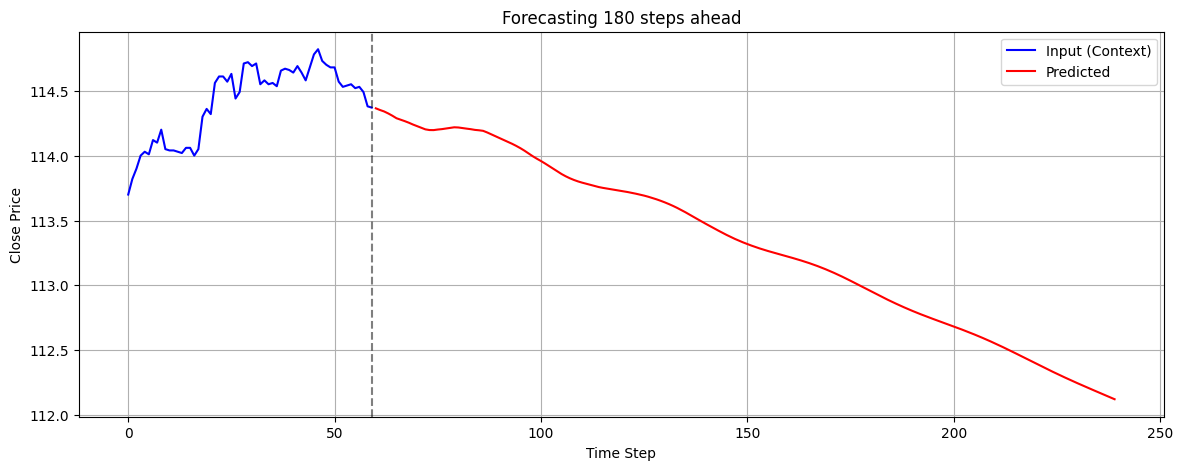

Predicting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4320/4320 [00:16<00:00, 256.16it/s]


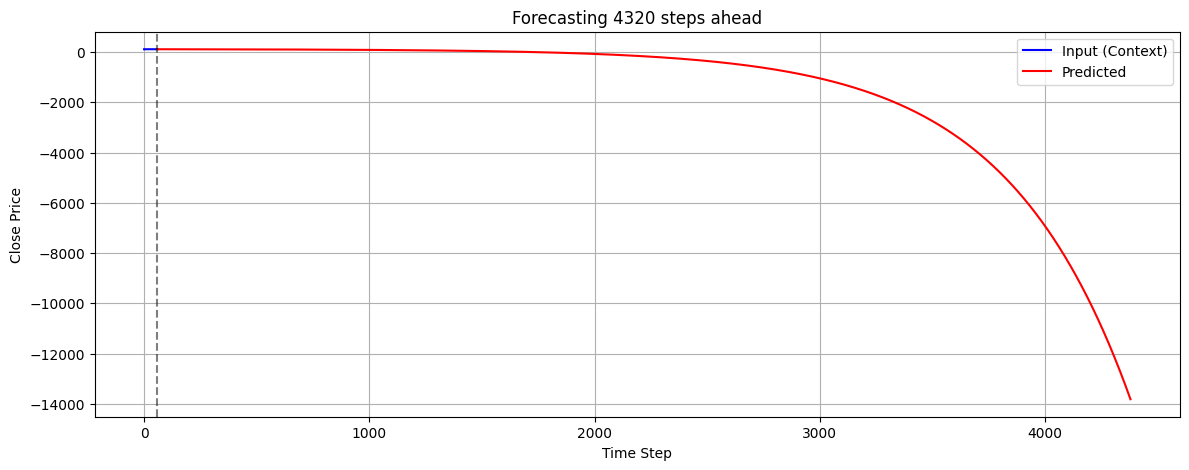

array([   114.36441686,    114.35164249,    114.3404265 , ...,
       -13767.42997088, -13792.44448388, -13817.50394861])

In [ ]:
def predict_autoregressive(model, series_raw, total_steps, context_length, scaler, plot_actual=True):
    model.eval()
    device = next(model.parameters()).device

    # Chu·∫©n h√≥a to√†n b·ªô chu·ªói g·ªëc
    series_scaled = scaler.transform(series_raw.reshape(-1, 1))

    # L·∫•y context cu·ªëi c√πng
    context = list(series_scaled[-context_length:].flatten())
    preds = []

    for _ in tqdm(range(total_steps), desc="Predicting"):
        input_seq = torch.tensor(context[-context_length:], dtype=torch.float).reshape(1, context_length, 1).to(device)
        with torch.no_grad():
            output = model(past_values=input_seq)
            pred = output.prediction_outputs[0, 0, 0].cpu().item()
        preds.append(pred)
        context.append(pred)

    # Inverse scale
    context_inv = scaler.inverse_transform(np.array(context[:context_length]).reshape(-1, 1)).flatten()
    preds_inv = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

    # N·∫øu c√≥ actual ƒë·ªÉ so s√°nh
    actual_inv = None
    if plot_actual and len(series_raw) >= context_length + total_steps:
        actual_inv = series_raw[-context_length: -context_length + total_steps]

    # V·∫Ω bi·ªÉu ƒë·ªì
    # V·∫Ω bi·ªÉu ƒë·ªì
    plt.figure(figsize=(14, 5))
    plt.plot(range(context_length), context_inv, label='Input (Context)', color='blue')
    if actual_inv is not None and len(actual_inv) == total_steps:
        plt.plot(range(context_length, context_length + total_steps), actual_inv, label='Actual', color='green')
    plt.plot(range(context_length, context_length + total_steps), preds_inv, label='Predicted', color='red')
    plt.axvline(context_length - 1, color='black', linestyle='--', alpha=0.5)
    plt.title(f'Forecasting {total_steps} steps ahead')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()


    return preds_inv


# D·ª± ƒëo√°n 3 gi·ªù = 180 ph√∫t
predict_autoregressive(model, series_full, total_steps=180, context_length=context_length, scaler=scaler)

# D·ª± ƒëo√°n 3 ng√†y = 3*24*60 = 4320 ph√∫t
predict_autoregressive(model, series_full, total_steps=4320, context_length=context_length, scaler=scaler)

# D·ª± ƒëo√°n 3 th√°ng = ~90 ng√†y = 129600 ph√∫t
# D·ª± ƒëo√°n 3 nƒÉm = ~1095 ng√†y = 1576800 ph√∫t (r·∫•t d√†i, c√≥ th·ªÉ gi·∫£m n·∫øu RAM/GPU y·∫øu)


Predicting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 180/180 [00:01<00:00, 107.42it/s]


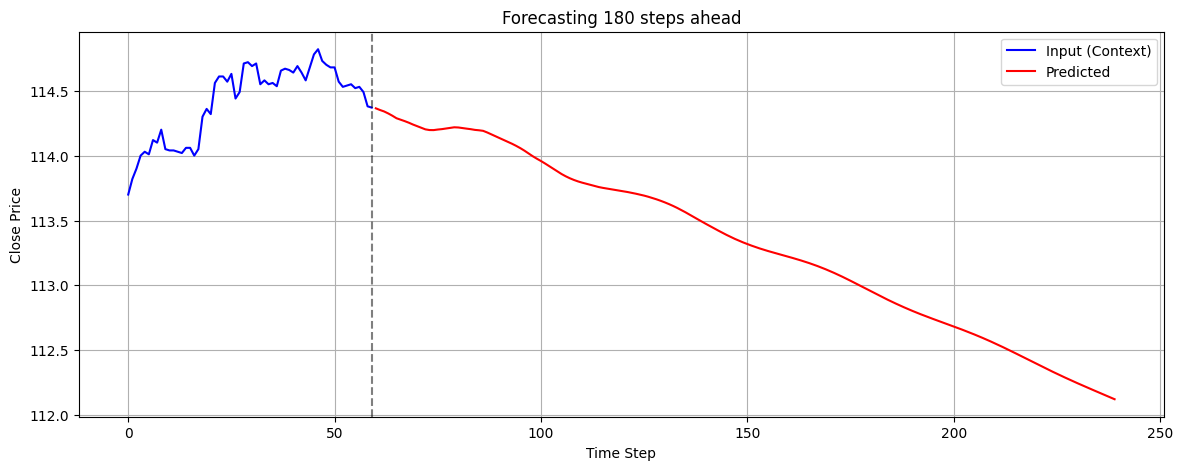

Predicting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4320/4320 [00:16<00:00, 268.65it/s]


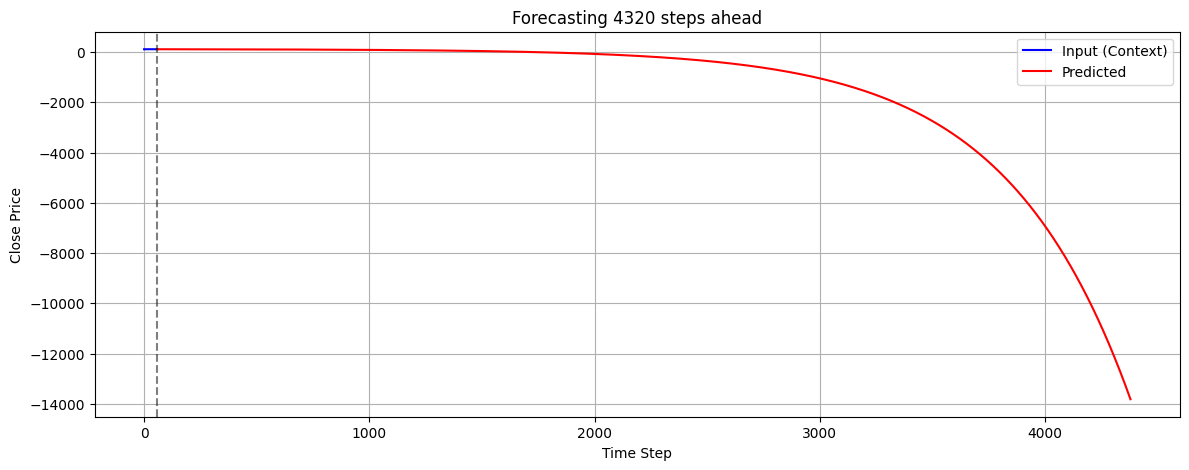

array([   114.36441686,    114.35164249,    114.3404265 , ...,
       -13767.42997088, -13792.44448388, -13817.50394861])

In [ ]:
def predict_autoregressive(model, series_raw, total_steps, context_length, scaler, plot_actual=True):
    model.eval()
    device = next(model.parameters()).device

    # Chu·∫©n h√≥a to√†n b·ªô chu·ªói g·ªëc
    series_scaled = scaler.transform(series_raw.reshape(-1, 1))

    # L·∫•y context cu·ªëi c√πng
    context = list(series_scaled[-context_length:].flatten())
    preds = []

    for _ in tqdm(range(total_steps), desc="Predicting"):
        input_seq = torch.tensor(context[-context_length:], dtype=torch.float).reshape(1, context_length, 1).to(device)
        with torch.no_grad():
            output = model(past_values=input_seq)
            pred = output.prediction_outputs[0, 0, 0].cpu().item()
        preds.append(pred)
        context.append(pred)

    # Inverse scale
    context_inv = scaler.inverse_transform(np.array(context[:context_length]).reshape(-1, 1)).flatten()
    preds_inv = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

    # L·∫•y ƒëo·∫°n actual n·∫øu c√≥ ƒë·ªß d·ªØ li·ªáu
    actual_inv = None
    actual_start = len(series_raw) - context_length
    actual_end = actual_start + total_steps
    if plot_actual and actual_end <= len(series_raw):
        actual_inv = series_raw[actual_start:actual_end]

    # V·∫Ω bi·ªÉu ƒë·ªì
    plt.figure(figsize=(14, 5))
    plt.plot(range(context_length), context_inv, label='Input (Context)', color='blue')
    if actual_inv is not None:
        plt.plot(range(context_length, context_length + len(actual_inv)), actual_inv, label='Actual', color='green')
    plt.plot(range(context_length, context_length + total_steps), preds_inv, label='Predicted', color='red')
    plt.axvline(context_length - 1, color='black', linestyle='--', alpha=0.5)
    plt.title(f'Forecasting {total_steps} steps ahead')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return preds_inv



# D·ª± ƒëo√°n 3 gi·ªù = 180 ph√∫t
predict_autoregressive(model, series_full, total_steps=180, context_length=context_length, scaler=scaler)

# D·ª± ƒëo√°n 3 ng√†y = 3*24*60 = 4320 ph√∫t
predict_autoregressive(model, series_full, total_steps=4320, context_length=context_length, scaler=scaler)

# D·ª± ƒëo√°n 3 th√°ng = ~90 ng√†y = 129600 ph√∫t
# D·ª± ƒëo√°n 3 nƒÉm = ~1095 ng√†y = 1576800 ph√∫t (r·∫•t d√†i, c√≥ th·ªÉ gi·∫£m n·∫øu RAM/GPU y·∫øu)


In [ ]:
def predict_autoregressive(model, series_raw, total_steps, context_length, scaler, start_pos=None, plot_actual=True):
    model.eval()
    device = next(model.parameters()).device

    # N·∫øu kh√¥ng truy·ªÅn start_pos th√¨ m·∫∑c ƒë·ªãnh l√† cu·ªëi chu·ªói
    if start_pos is None:
        start_pos = len(series_raw) - context_length

    # ƒê·∫£m b·∫£o kh√¥ng v∆∞·ª£t ra ngo√†i gi·ªõi h·∫°n
    if start_pos < 0 or start_pos + context_length + total_steps > len(series_raw):
        raise ValueError("start_pos + context_length + total_steps v∆∞·ª£t qu√° ƒë·ªô d√†i chu·ªói")

    # Chu·∫©n h√≥a to√†n b·ªô chu·ªói
    series_scaled = scaler.transform(series_raw.reshape(-1, 1))

    # L·∫•y context v√† actual t·ª´ v·ªã tr√≠ ch·ªâ ƒë·ªãnh
    context = list(series_scaled[start_pos: start_pos + context_length].flatten())
    preds = []

    for _ in tqdm(range(total_steps), desc="Predicting"):
        input_seq = torch.tensor(context[-context_length:], dtype=torch.float).reshape(1, context_length, 1).to(device)
        with torch.no_grad():
            output = model(past_values=input_seq)
            pred = output.prediction_outputs[0, 0, 0].cpu().item()
        preds.append(pred)
        context.append(pred)

    # Inverse scale
    context_inv = scaler.inverse_transform(np.array(context[:context_length]).reshape(-1, 1)).flatten()
    preds_inv = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    actual_inv = series_raw[start_pos + context_length: start_pos + context_length + total_steps]

    # V·∫Ω bi·ªÉu ƒë·ªì
    plt.figure(figsize=(14, 5))
    plt.plot(range(context_length), context_inv, label='Input (Context)', color='blue')
    if plot_actual:
        plt.plot(range(context_length, context_length + total_steps), actual_inv, label='Actual', color='green')
    plt.plot(range(context_length, context_length + total_steps), preds_inv, label='Predicted', color='red')
    plt.axvline(context_length - 1, color='black', linestyle='--', alpha=0.5)
    plt.title(f'Forecasting {total_steps} steps ahead from pos {start_pos}')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return preds_inv


Predicting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4320/4320 [00:16<00:00, 262.31it/s]


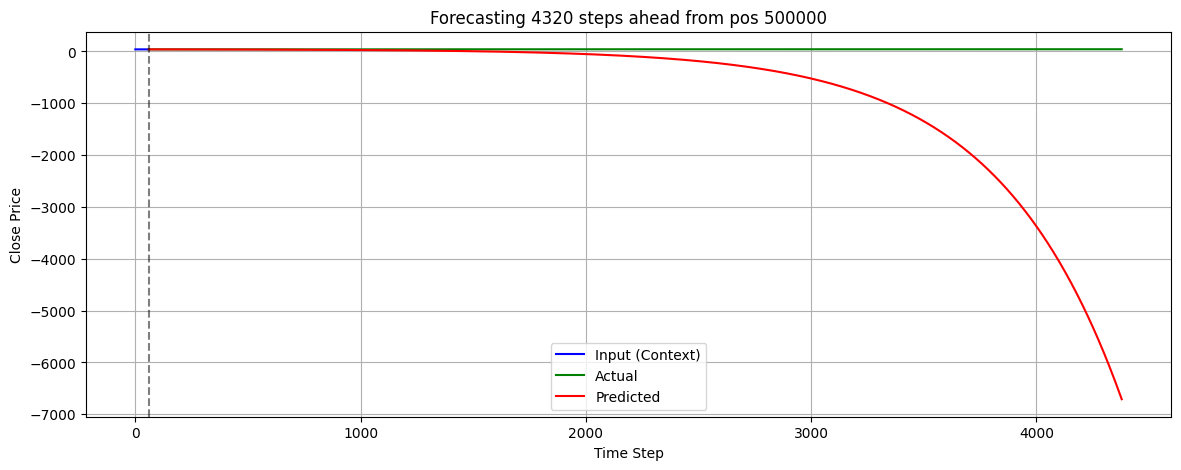

array([   39.71497645,    39.71127419,    39.70727616, ...,
       -6685.74649696, -6697.864921  , -6710.00525902])

In [ ]:
predict_autoregressive(
    model,
    series_full,
    total_steps=4320,
    context_length=context_length,
    scaler=scaler,
    start_pos=500000  # l·∫•y context t·ª´ gi·ªØa chu·ªói
)


Predicting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4320/4320 [00:16<00:00, 267.37it/s]


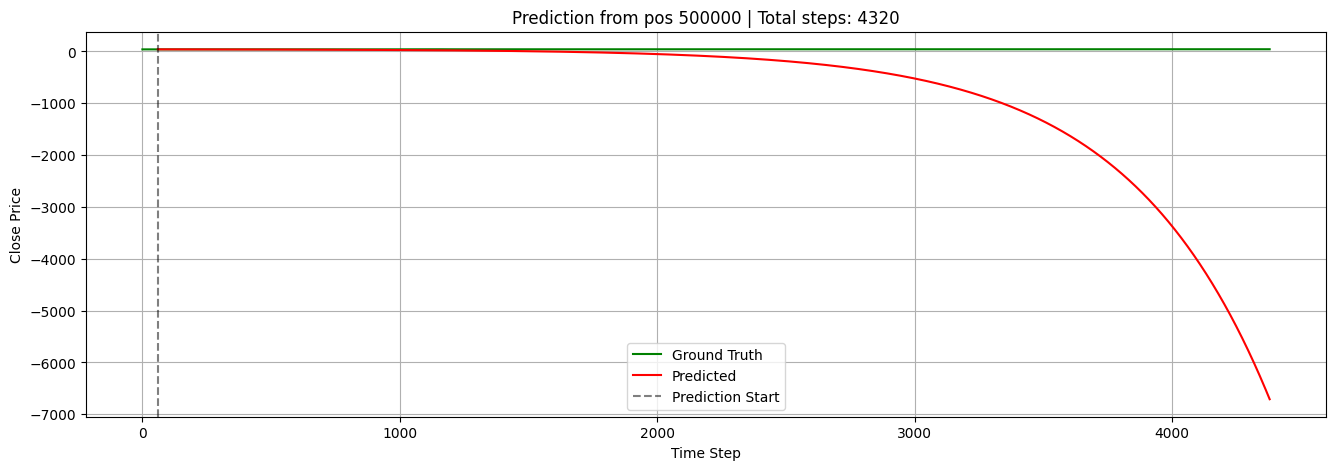

array([   39.71497645,    39.71127419,    39.70727616, ...,
       -6685.74649696, -6697.864921  , -6710.00525902])

In [ ]:
def predict_autoregressive(model, series_raw, total_steps, context_length, scaler, start_pos=None, plot_actual=True):
    model.eval()
    device = next(model.parameters()).device

    # M·∫∑c ƒë·ªãnh l·∫•y t·ª´ g·∫ßn cu·ªëi chu·ªói
    if start_pos is None:
        start_pos = len(series_raw) - (context_length + total_steps)

    # Ki·ªÉm tra ƒë·ªô d√†i h·ª£p l·ªá
    if start_pos < 0 or start_pos + context_length + total_steps > len(series_raw):
        raise ValueError("start_pos + context_length + total_steps v∆∞·ª£t qu√° ƒë·ªô d√†i chu·ªói")

    # Chu·∫©n h√≥a chu·ªói
    series_scaled = scaler.transform(series_raw.reshape(-1, 1))

    # L·∫•y context v√† actual t·ª´ start_pos
    context = list(series_scaled[start_pos: start_pos + context_length].flatten())
    preds = []

    for _ in tqdm(range(total_steps), desc="Predicting"):
        input_seq = torch.tensor(context[-context_length:], dtype=torch.float).reshape(1, context_length, 1).to(device)
        with torch.no_grad():
            output = model(past_values=input_seq)
            pred = output.prediction_outputs[0, 0, 0].cpu().item()
        preds.append(pred)
        context.append(pred)

    # Chu·∫©n b·ªã cho v·∫Ω
    full_len = context_length + total_steps
    full_input = series_raw[start_pos: start_pos + context_length + total_steps]
    preds_only = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

    # V·∫Ω bi·ªÉu ƒë·ªì to√†n b·ªô ƒëo·∫°n test
    plt.figure(figsize=(16, 5))
    plt.plot(range(full_len), full_input, label='Ground Truth', color='green')
    plt.plot(range(context_length, context_length + total_steps), preds_only, label='Predicted', color='red')
    plt.axvline(context_length - 1, color='black', linestyle='--', alpha=0.5, label='Prediction Start')
    plt.title(f"Prediction from pos {start_pos} | Total steps: {total_steps}")
    plt.xlabel("Time Step")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    return preds_only
# D·ª± ƒëo√°n 3 ng√†y t·ª´ gi·ªØa chu·ªói
predict_autoregressive(
    model,
    series_raw=series_full,
    total_steps=4320,
    context_length=context_length,
    scaler=scaler,
    start_pos=500000  # v√≠ d·ª• gi·ªØa chu·ªói
)


Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24236/24236 [04:40<00:00, 86.46it/s]


Epoch 1 Loss: 0.0003


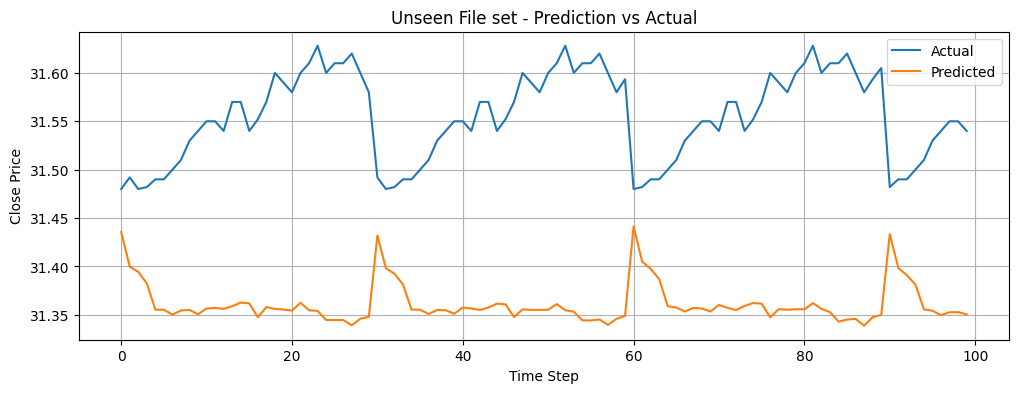

Epoch 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24236/24236 [04:41<00:00, 86.00it/s]


Epoch 2 Loss: 0.0003


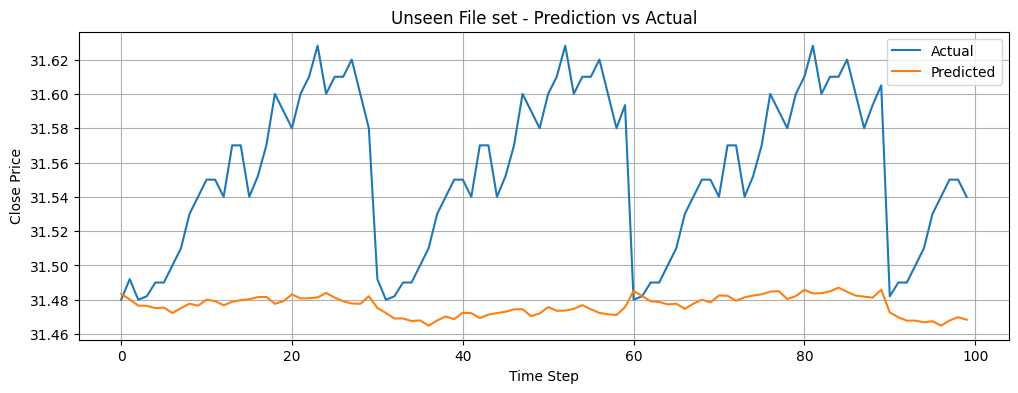

Epoch 3: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24236/24236 [04:44<00:00, 85.22it/s]


Epoch 3 Loss: 0.0003


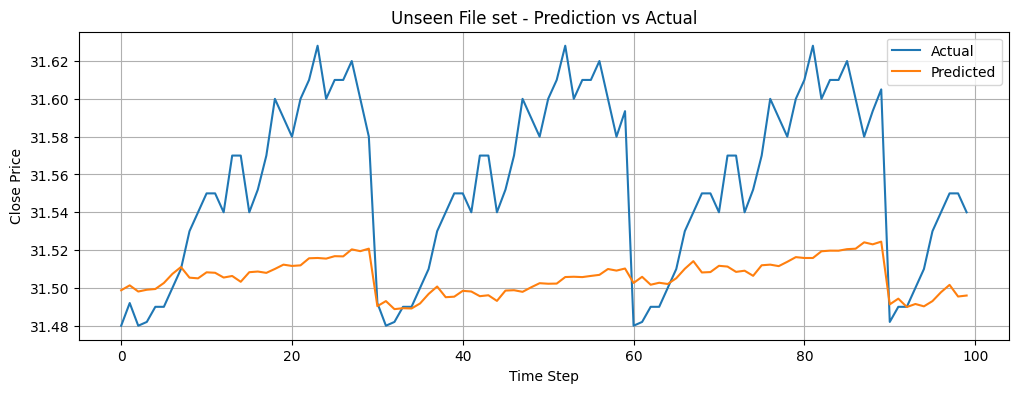

Epoch 4: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24236/24236 [04:44<00:00, 85.13it/s]


Epoch 4 Loss: 0.0003


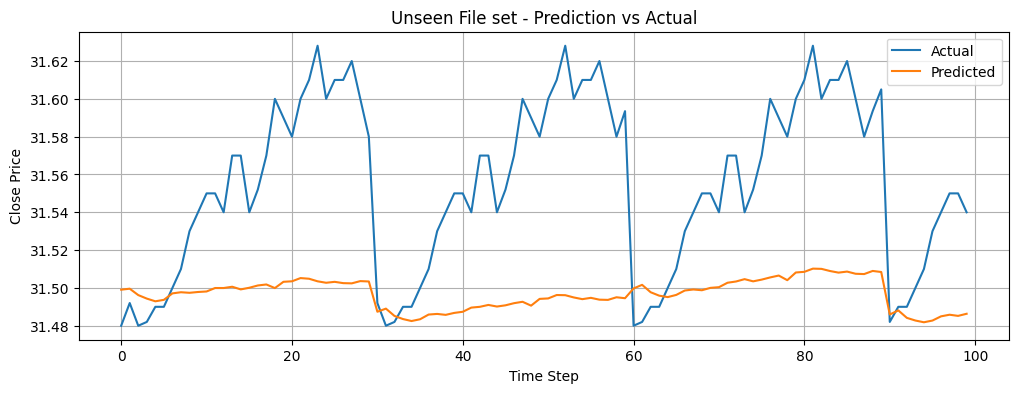

Epoch 5: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24236/24236 [04:45<00:00, 84.90it/s]


Epoch 5 Loss: 0.0003


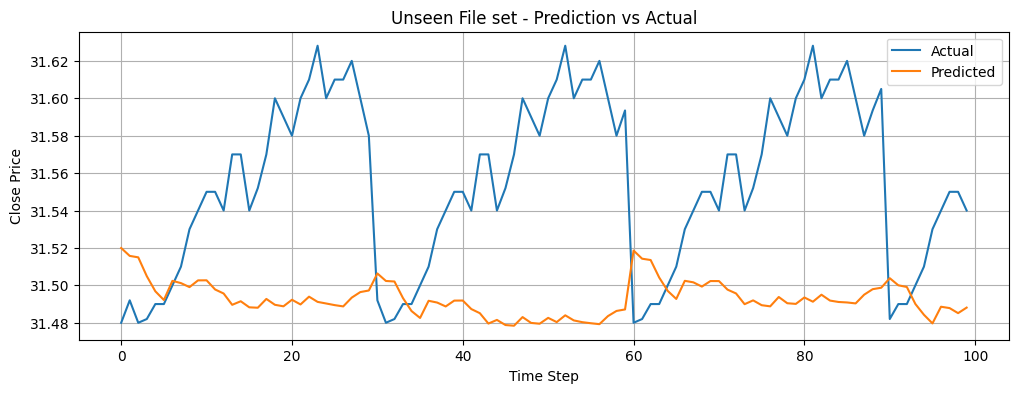

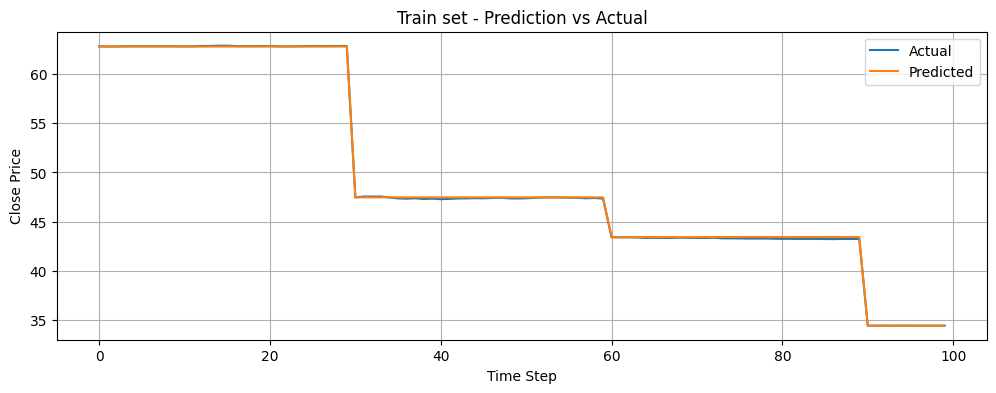

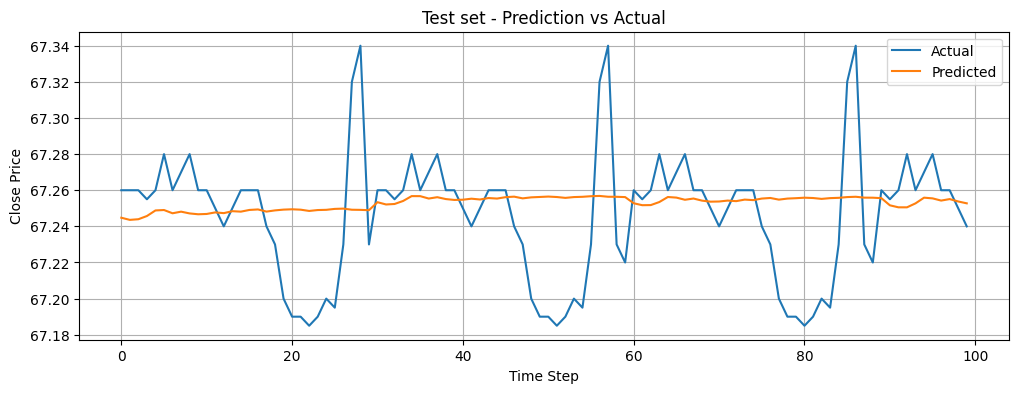

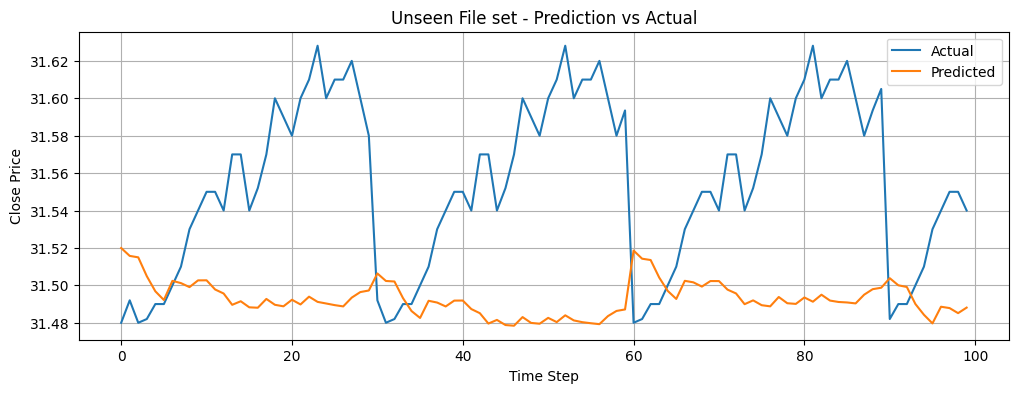

In [ ]:
# --- 1. Th∆∞ vi·ªán ---
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from transformers import PatchTSTConfig, PatchTSTForPrediction
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 2. ƒê·ªçc v√† chu·∫©n h√≥a d·ªØ li·ªáu hu·∫•n luy·ªán ---
df = pd.read_parquet('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet')
series = df['close'].dropna().values.reshape(-1, 1)

# Chia train/test
train_size = int(0.8 * len(series))
train_series = series[:train_size]
test_series = series[train_size:]

# Chu·∫©n h√≥a ch·ªâ tr√™n train
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_series)
test_scaled = scaler.transform(test_series)

# --- 3. Dataset ---
class TimeSeriesDataset(Dataset):
    def __init__(self, series, context_length, prediction_length):
        self.series = series
        self.context_length = context_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.series) - self.context_length - self.prediction_length

    def __getitem__(self, idx):
        x = self.series[idx : idx + self.context_length]
        y = self.series[idx + self.context_length : idx + self.context_length + self.prediction_length]
        return {
            'past_values': torch.tensor(x, dtype=torch.float),
            'future_values': torch.tensor(y, dtype=torch.float),
        }

context_length = 60
prediction_length = 30

train_dataset = TimeSeriesDataset(train_scaled, context_length, prediction_length)
test_dataset = TimeSeriesDataset(test_scaled, context_length, prediction_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- 4. C·∫•u h√¨nh v√† t·∫°o model ---
config = PatchTSTConfig(
    context_length=context_length,
    prediction_length=prediction_length,
    patch_len=10,
    stride=10,
    d_model=64,
    num_layers=2,
    num_heads=2,
    dropout=0.1,
    target_dim=1,
)
model = PatchTSTForPrediction(config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# --- 5. Hu·∫•n luy·ªán ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x = batch['past_values'].to(device)
        y = batch['future_values'].to(device)

        outputs = model(past_values=x)
        pred = outputs.prediction_outputs
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")
    predict_on_new_file('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet', name="Unseen File")


# --- 6. H√†m d·ª± ƒëo√°n ---
def predict_and_plot(loader, name="Test"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)
            output = model(past_values=x).prediction_outputs
            preds.append(output.cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_inv = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    plt.figure(figsize=(12, 4))
    plt.plot(trues_inv[:100], label='Actual')
    plt.plot(preds_inv[:100], label='Predicted')
    plt.title(f'{name} set - Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 7. Tr·ª±c quan h√≥a ---
predict_and_plot(train_loader, "Train")
predict_and_plot(test_loader, "Test")

# --- 8. D·ª± ƒëo√°n tr√™n file ch∆∞a hu·∫•n luy·ªán ---
def predict_on_new_file(parquet_path, name="External"):
    df_new = pd.read_parquet(parquet_path)
    new_series = df_new['close'].dropna().values.reshape(-1, 1)
    new_scaled = scaler.transform(new_series)  # d√πng scaler ƒë√£ fit t·ª´ train
    new_dataset = TimeSeriesDataset(new_scaled, context_length, prediction_length)
    new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)
    predict_and_plot(new_loader, name)

# G·ªçi th·ª≠:
# predict_on_new_file('/content/drive/MyDrive/Draft/TimeSeries/Demo_Data_5/GOOGL-MINUTES1.parquet', name="Unseen File")
predict_on_new_file('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet', name="Unseen File")



Processing BaÃân sao cuÃâa BAC-MINUTES1.parquet (1 of 50)


Training BaÃân sao cuÃâa BAC-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:24<00:00, 85.39it/s]


BaÃân sao cuÃâa BAC-MINUTES1.parquet - Epoch 1 Train Loss: 0.000084
BaÃân sao cuÃâa BAC-MINUTES1.parquet - Epoch 1 VAL MAE: 0.055527
‚úÖ Saved better model!
üìâ Saved loss log to loss_BaÃân sao cuÃâa BAC-MINUTES1.csv


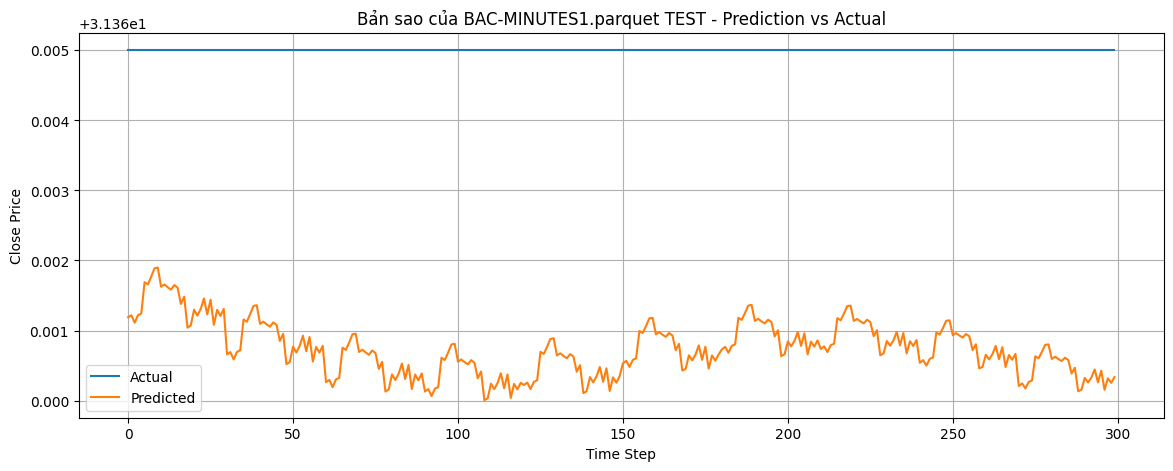


Processing BaÃân sao cuÃâa GDX-MINUTES1.parquet (2 of 50)


Training BaÃân sao cuÃâa GDX-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:23<00:00, 85.76it/s]


BaÃân sao cuÃâa GDX-MINUTES1.parquet - Epoch 1 Train Loss: 0.000566
BaÃân sao cuÃâa GDX-MINUTES1.parquet - Epoch 1 VAL MAE: 0.061853
üìâ Saved loss log to loss_BaÃân sao cuÃâa GDX-MINUTES1.csv


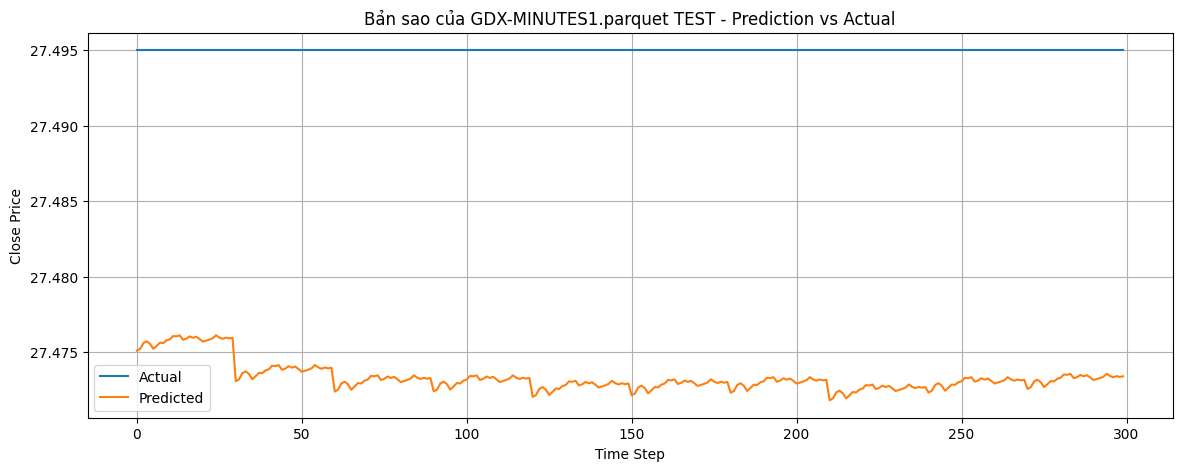


Processing BaÃân sao cuÃâa GILD-MINUTES1.parquet (3 of 50)


Training BaÃân sao cuÃâa GILD-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 26888/26888 [05:12<00:00, 86.14it/s]


BaÃân sao cuÃâa GILD-MINUTES1.parquet - Epoch 1 Train Loss: 0.002589
BaÃân sao cuÃâa GILD-MINUTES1.parquet - Epoch 1 VAL MAE: 0.444971
üìâ Saved loss log to loss_BaÃân sao cuÃâa GILD-MINUTES1.csv


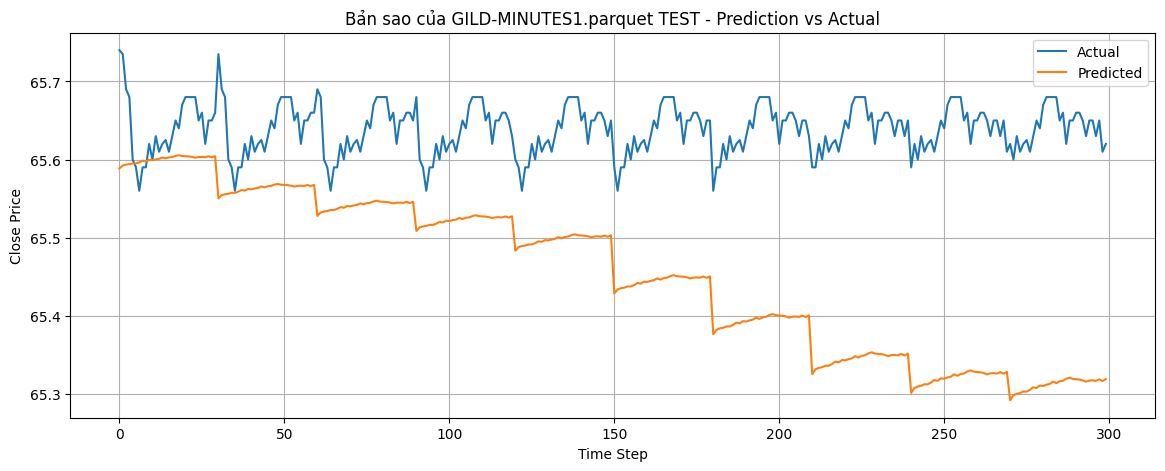


Processing BaÃân sao cuÃâa C-MINUTES1.parquet (4 of 50)


Training BaÃân sao cuÃâa C-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:27<00:00, 84.65it/s]


BaÃân sao cuÃâa C-MINUTES1.parquet - Epoch 1 Train Loss: 0.001426
BaÃân sao cuÃâa C-MINUTES1.parquet - Epoch 1 VAL MAE: 0.138643
üìâ Saved loss log to loss_BaÃân sao cuÃâa C-MINUTES1.csv


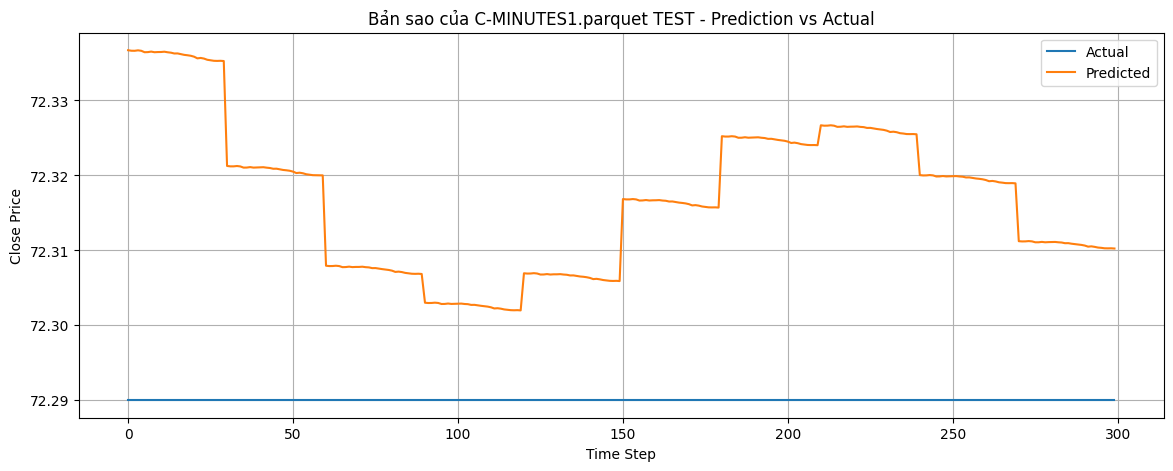


Processing BaÃân sao cuÃâa JPM-MINUTES1.parquet (5 of 50)


Training BaÃân sao cuÃâa JPM-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 26888/26888 [05:18<00:00, 84.53it/s]


BaÃân sao cuÃâa JPM-MINUTES1.parquet - Epoch 1 Train Loss: 0.000782
BaÃân sao cuÃâa JPM-MINUTES1.parquet - Epoch 1 VAL MAE: 0.597097
üìâ Saved loss log to loss_BaÃân sao cuÃâa JPM-MINUTES1.csv


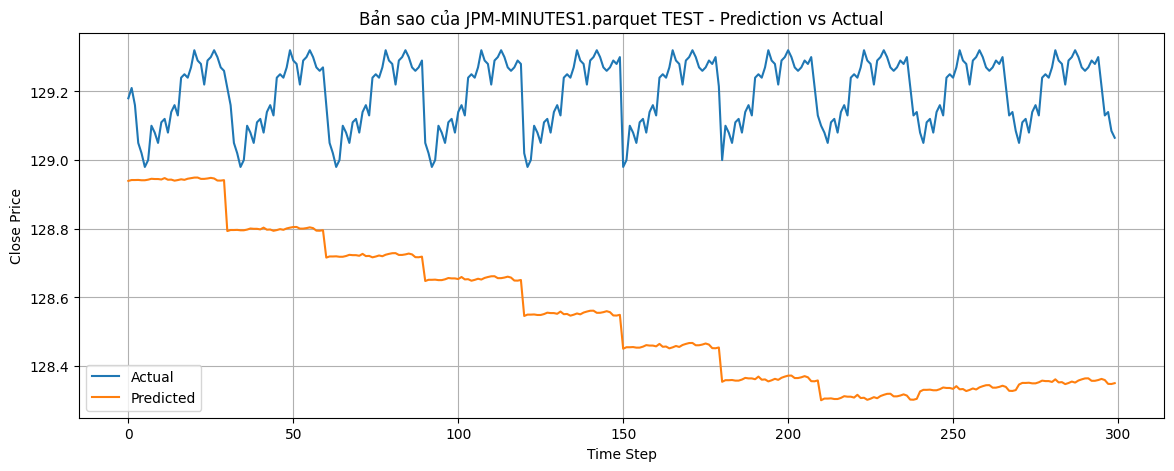


Processing BaÃân sao cuÃâa AAPL-MINUTES1.parquet (6 of 50)


Training BaÃân sao cuÃâa AAPL-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:26<00:00, 84.89it/s]


BaÃân sao cuÃâa AAPL-MINUTES1.parquet - Epoch 1 Train Loss: 0.195381
BaÃân sao cuÃâa AAPL-MINUTES1.parquet - Epoch 1 VAL MAE: 0.383784
üìâ Saved loss log to loss_BaÃân sao cuÃâa AAPL-MINUTES1.csv


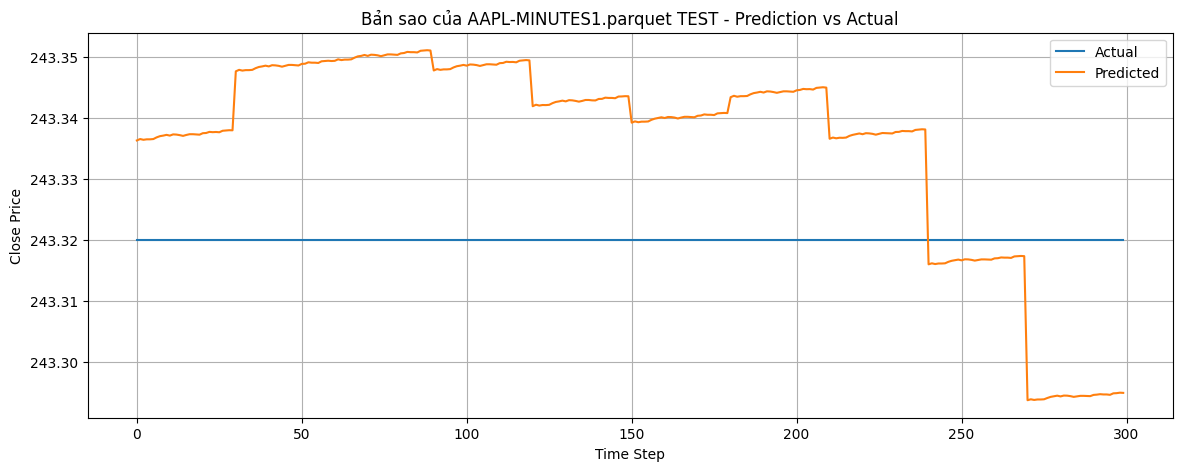


Processing BaÃân sao cuÃâa VTRS-MINUTES1.parquet (7 of 50)


Training BaÃân sao cuÃâa VTRS-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 66/66 [00:00<00:00, 86.02it/s]


BaÃân sao cuÃâa VTRS-MINUTES1.parquet - Epoch 1 Train Loss: 0.000532
BaÃân sao cuÃâa VTRS-MINUTES1.parquet - Epoch 1 VAL MAE: 0.061080
üìâ Saved loss log to loss_BaÃân sao cuÃâa VTRS-MINUTES1.csv


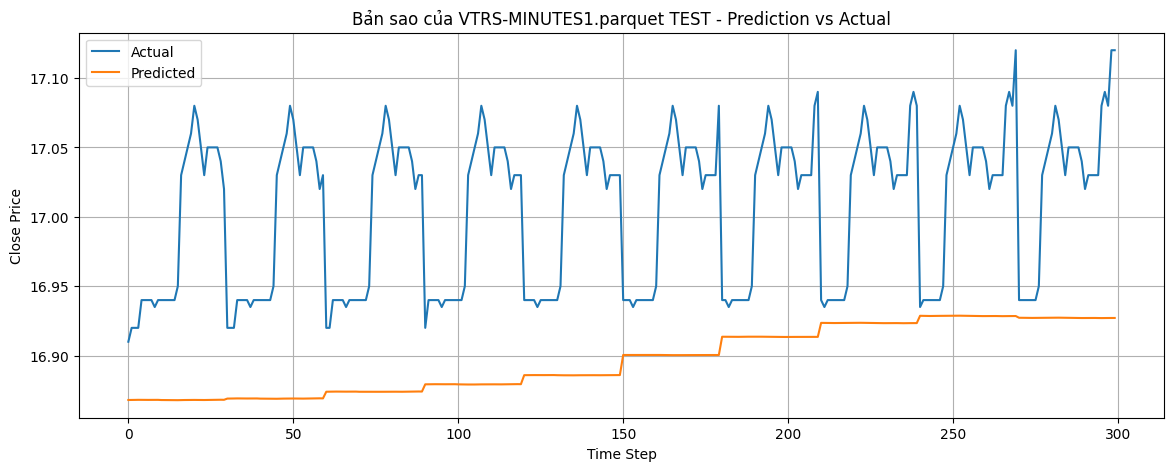


Processing BaÃân sao cuÃâa ATVI-MINUTES1.parquet (8 of 50)


Training BaÃân sao cuÃâa ATVI-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:27<00:00, 84.71it/s]


BaÃân sao cuÃâa ATVI-MINUTES1.parquet - Epoch 1 Train Loss: 0.000363
BaÃân sao cuÃâa ATVI-MINUTES1.parquet - Epoch 1 VAL MAE: 0.306337
üìâ Saved loss log to loss_BaÃân sao cuÃâa ATVI-MINUTES1.csv


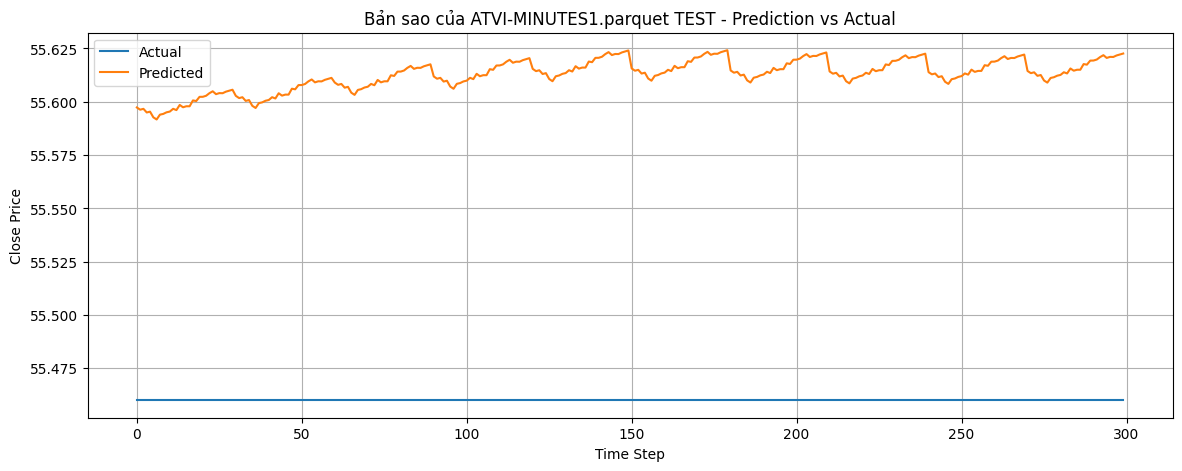


Processing BaÃân sao cuÃâa SPY-MINUTES1.parquet (9 of 50)


Training BaÃân sao cuÃâa SPY-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27658/27658 [05:27<00:00, 84.47it/s]


BaÃân sao cuÃâa SPY-MINUTES1.parquet - Epoch 1 Train Loss: 0.002750
BaÃân sao cuÃâa SPY-MINUTES1.parquet - Epoch 1 VAL MAE: 0.320275
üìâ Saved loss log to loss_BaÃân sao cuÃâa SPY-MINUTES1.csv


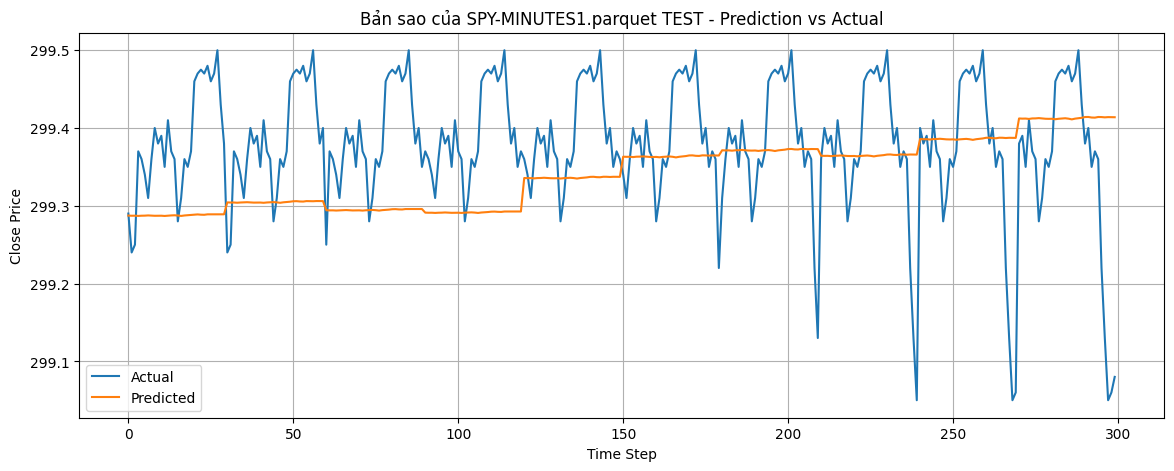


Processing BaÃân sao cuÃâa DIS-MINUTES1.parquet (10 of 50)


Training BaÃân sao cuÃâa DIS-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:29<00:00, 84.09it/s]


BaÃân sao cuÃâa DIS-MINUTES1.parquet - Epoch 1 Train Loss: 0.000926
BaÃân sao cuÃâa DIS-MINUTES1.parquet - Epoch 1 VAL MAE: 0.723369
üìâ Saved loss log to loss_BaÃân sao cuÃâa DIS-MINUTES1.csv



Processing BaÃân sao cuÃâa AMAT-MINUTES1.parquet (11 of 50)


Training BaÃân sao cuÃâa AMAT-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:28<00:00, 84.45it/s]


BaÃân sao cuÃâa AMAT-MINUTES1.parquet - Epoch 1 Train Loss: 0.000253
BaÃân sao cuÃâa AMAT-MINUTES1.parquet - Epoch 1 VAL MAE: 0.395456
üìâ Saved loss log to loss_BaÃân sao cuÃâa AMAT-MINUTES1.csv


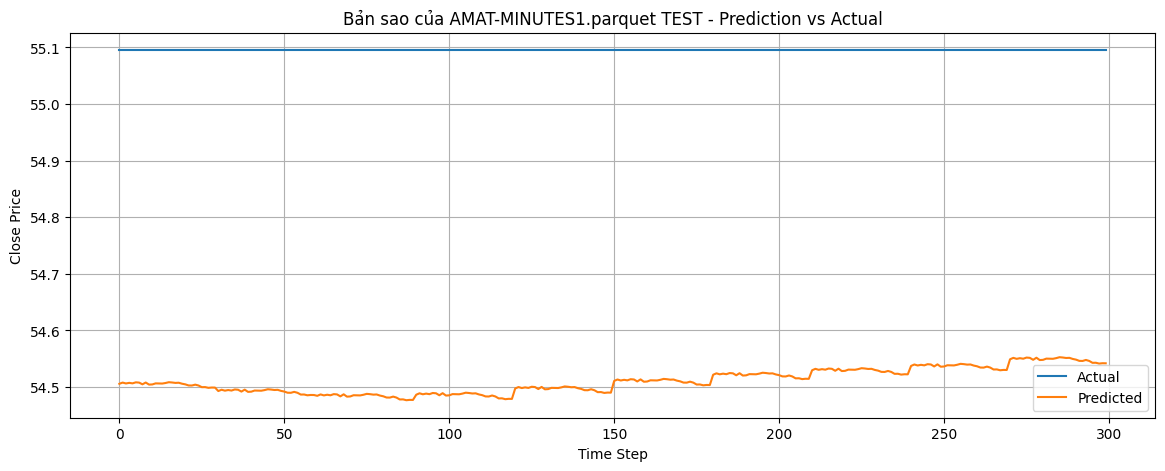


Processing BaÃân sao cuÃâa KO-MINUTES1.parquet (12 of 50)


Training BaÃân sao cuÃâa KO-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:29<00:00, 84.03it/s]


BaÃân sao cuÃâa KO-MINUTES1.parquet - Epoch 1 Train Loss: 0.001031
BaÃân sao cuÃâa KO-MINUTES1.parquet - Epoch 1 VAL MAE: 0.058090
üìâ Saved loss log to loss_BaÃân sao cuÃâa KO-MINUTES1.csv


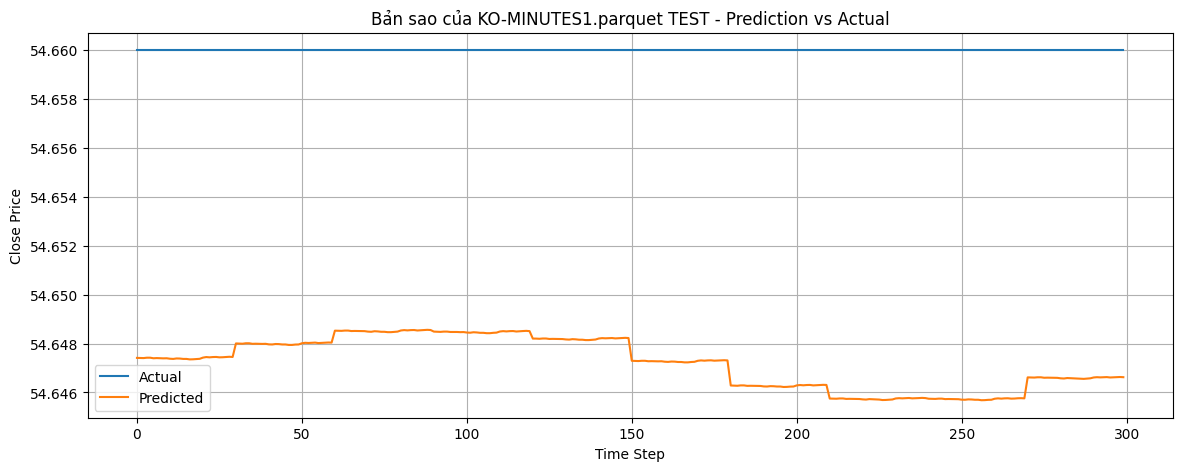


Processing BaÃân sao cuÃâa JNJ-MINUTES1.parquet (13 of 50)


Training BaÃân sao cuÃâa JNJ-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:37<00:00, 82.05it/s]


BaÃân sao cuÃâa JNJ-MINUTES1.parquet - Epoch 1 Train Loss: 0.000770
BaÃân sao cuÃâa JNJ-MINUTES1.parquet - Epoch 1 VAL MAE: 0.175462
üìâ Saved loss log to loss_BaÃân sao cuÃâa JNJ-MINUTES1.csv



Processing BaÃân sao cuÃâa CVX-MINUTES1.parquet (14 of 50)


Training BaÃân sao cuÃâa CVX-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:41<00:00, 81.19it/s]


BaÃân sao cuÃâa CVX-MINUTES1.parquet - Epoch 1 Train Loss: 0.001839
BaÃân sao cuÃâa CVX-MINUTES1.parquet - Epoch 1 VAL MAE: 0.804319
üìâ Saved loss log to loss_BaÃân sao cuÃâa CVX-MINUTES1.csv



Processing BaÃân sao cuÃâa BA-MINUTES1.parquet (15 of 50)


Training BaÃân sao cuÃâa BA-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:34<00:00, 82.76it/s]


BaÃân sao cuÃâa BA-MINUTES1.parquet - Epoch 1 Train Loss: 0.005746
BaÃân sao cuÃâa BA-MINUTES1.parquet - Epoch 1 VAL MAE: 2.353989
üìâ Saved loss log to loss_BaÃân sao cuÃâa BA-MINUTES1.csv



Processing BaÃân sao cuÃâa EEM-MINUTES1.parquet (16 of 50)


Training BaÃân sao cuÃâa EEM-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:33<00:00, 83.07it/s]


BaÃân sao cuÃâa EEM-MINUTES1.parquet - Epoch 1 Train Loss: 0.003952
BaÃân sao cuÃâa EEM-MINUTES1.parquet - Epoch 1 VAL MAE: 0.047970
‚úÖ Saved better model!
üìâ Saved loss log to loss_BaÃân sao cuÃâa EEM-MINUTES1.csv



Processing BaÃân sao cuÃâa INTC-MINUTES1.parquet (17 of 50)


Training BaÃân sao cuÃâa INTC-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 26888/26888 [05:24<00:00, 82.96it/s]


BaÃân sao cuÃâa INTC-MINUTES1.parquet - Epoch 1 Train Loss: 0.000242
BaÃân sao cuÃâa INTC-MINUTES1.parquet - Epoch 1 VAL MAE: 0.173783
üìâ Saved loss log to loss_BaÃân sao cuÃâa INTC-MINUTES1.csv



Processing BaÃân sao cuÃâa EFA-MINUTES1.parquet (18 of 50)


Training BaÃân sao cuÃâa EFA-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:35<00:00, 82.50it/s]


BaÃân sao cuÃâa EFA-MINUTES1.parquet - Epoch 1 Train Loss: 0.002694
BaÃân sao cuÃâa EFA-MINUTES1.parquet - Epoch 1 VAL MAE: 0.052032
üìâ Saved loss log to loss_BaÃân sao cuÃâa EFA-MINUTES1.csv


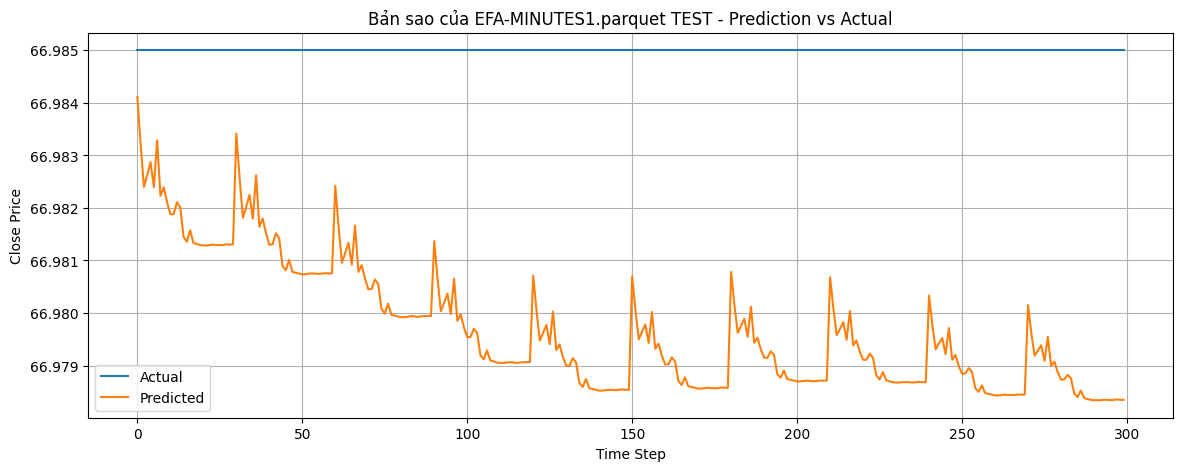


Processing BaÃân sao cuÃâa CSCO-MINUTES1.parquet (19 of 50)


Training BaÃân sao cuÃâa CSCO-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:37<00:00, 82.13it/s]


BaÃân sao cuÃâa CSCO-MINUTES1.parquet - Epoch 1 Train Loss: 0.000161
BaÃân sao cuÃâa CSCO-MINUTES1.parquet - Epoch 1 VAL MAE: 0.157881
üìâ Saved loss log to loss_BaÃân sao cuÃâa CSCO-MINUTES1.csv



Processing BaÃân sao cuÃâa EXC-MINUTES1.parquet (20 of 50)


Training BaÃân sao cuÃâa EXC-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:37<00:00, 82.14it/s]


BaÃân sao cuÃâa EXC-MINUTES1.parquet - Epoch 1 Train Loss: 0.000206
BaÃân sao cuÃâa EXC-MINUTES1.parquet - Epoch 1 VAL MAE: 0.066057
üìâ Saved loss log to loss_BaÃân sao cuÃâa EXC-MINUTES1.csv


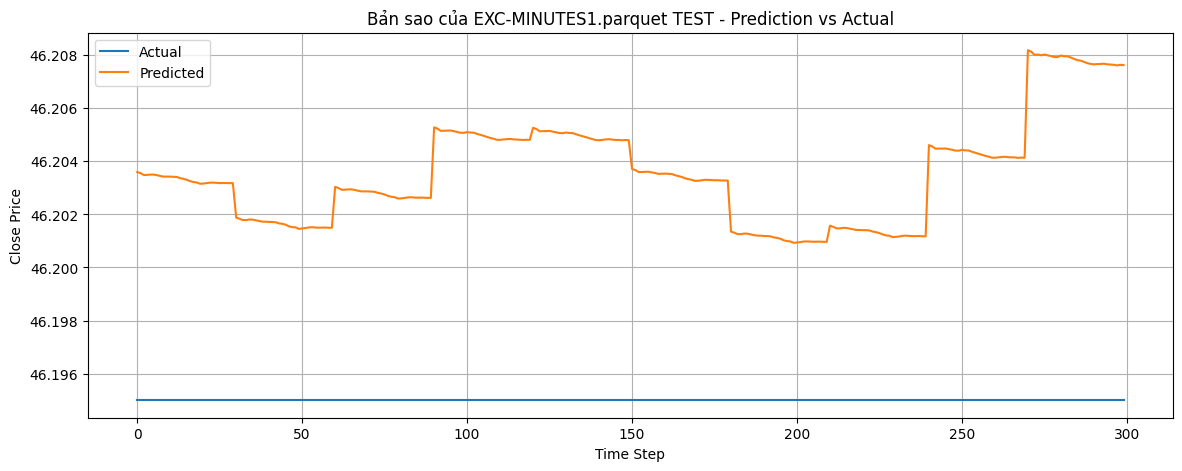


Processing BaÃân sao cuÃâa CAT-MINUTES1.parquet (21 of 50)


Training BaÃân sao cuÃâa CAT-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:39<00:00, 81.66it/s]


BaÃân sao cuÃâa CAT-MINUTES1.parquet - Epoch 1 Train Loss: 0.002584
BaÃân sao cuÃâa CAT-MINUTES1.parquet - Epoch 1 VAL MAE: 2.044043
üìâ Saved loss log to loss_BaÃân sao cuÃâa CAT-MINUTES1.csv


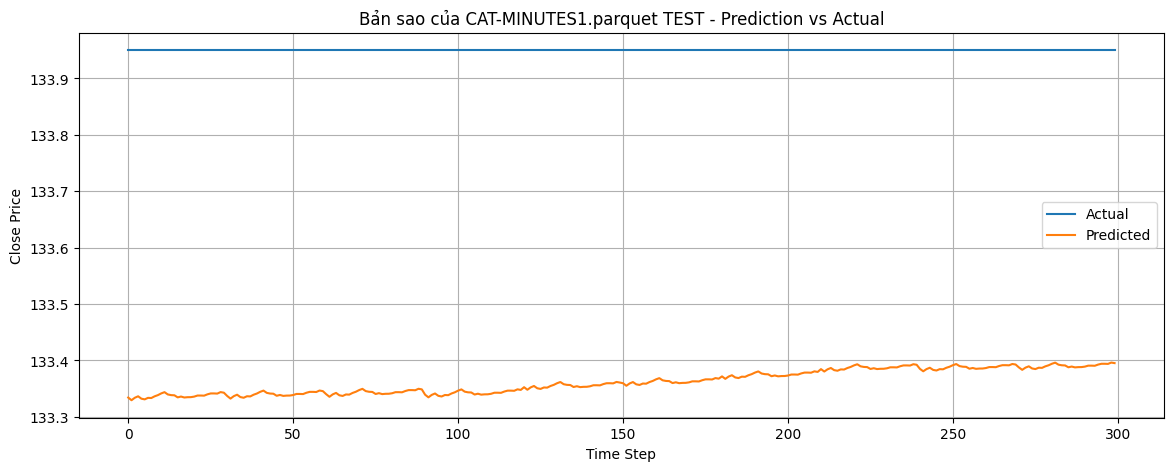


Processing BaÃân sao cuÃâa MU-MINUTES1.parquet (22 of 50)


Training BaÃân sao cuÃâa MU-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 23690/23690 [04:52<00:00, 81.04it/s]


BaÃân sao cuÃâa MU-MINUTES1.parquet - Epoch 1 Train Loss: 0.000508
BaÃân sao cuÃâa MU-MINUTES1.parquet - Epoch 1 VAL MAE: 0.638873
üìâ Saved loss log to loss_BaÃân sao cuÃâa MU-MINUTES1.csv


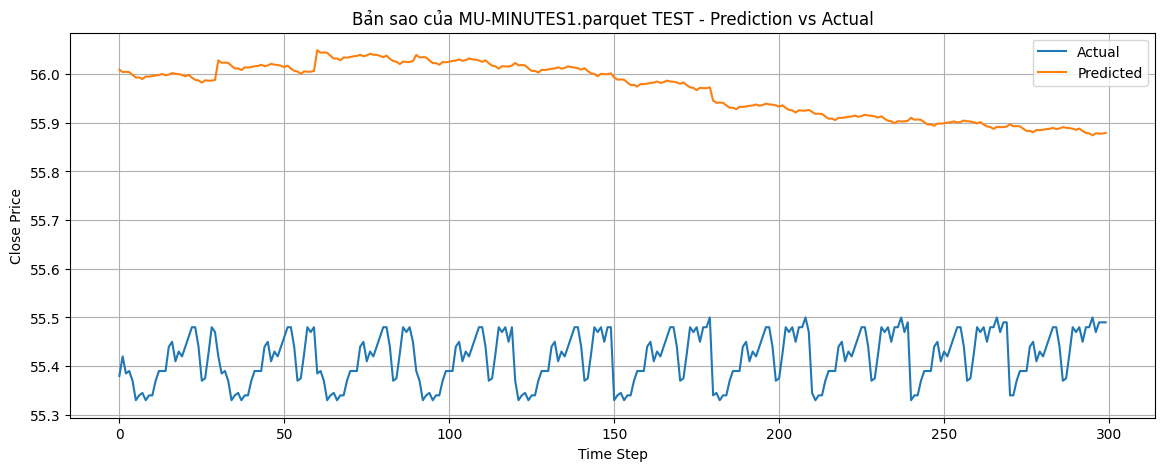


Processing BaÃân sao cuÃâa HD-MINUTES1.parquet (23 of 50)


Training BaÃân sao cuÃâa HD-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:44<00:00, 80.35it/s]


BaÃân sao cuÃâa HD-MINUTES1.parquet - Epoch 1 Train Loss: 0.001394
BaÃân sao cuÃâa HD-MINUTES1.parquet - Epoch 1 VAL MAE: 0.713963
üìâ Saved loss log to loss_BaÃân sao cuÃâa HD-MINUTES1.csv


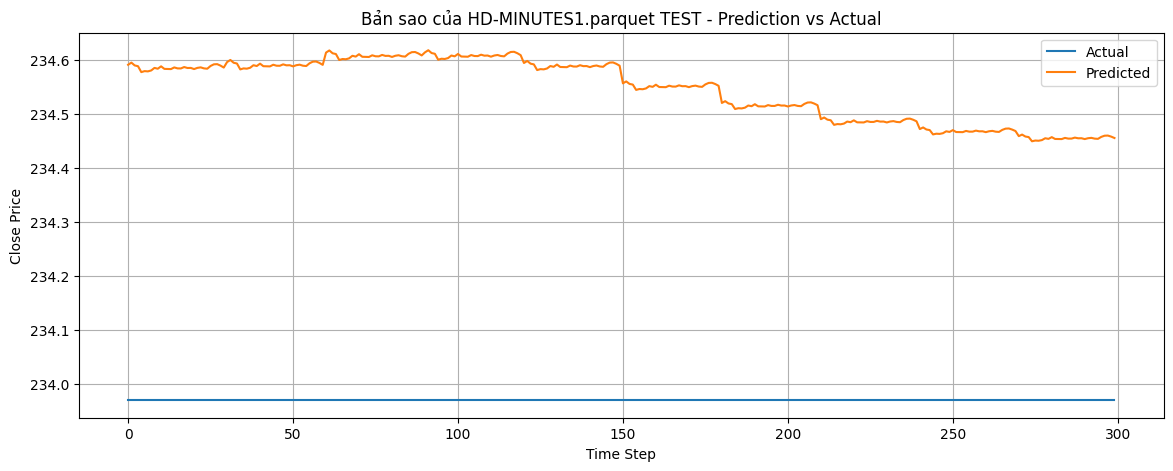


Processing BaÃân sao cuÃâa VNQ-MINUTES1.parquet (24 of 50)


Training BaÃân sao cuÃâa VNQ-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:47<00:00, 79.78it/s]


BaÃân sao cuÃâa VNQ-MINUTES1.parquet - Epoch 1 Train Loss: 0.000507
BaÃân sao cuÃâa VNQ-MINUTES1.parquet - Epoch 1 VAL MAE: 0.101084
üìâ Saved loss log to loss_BaÃân sao cuÃâa VNQ-MINUTES1.csv


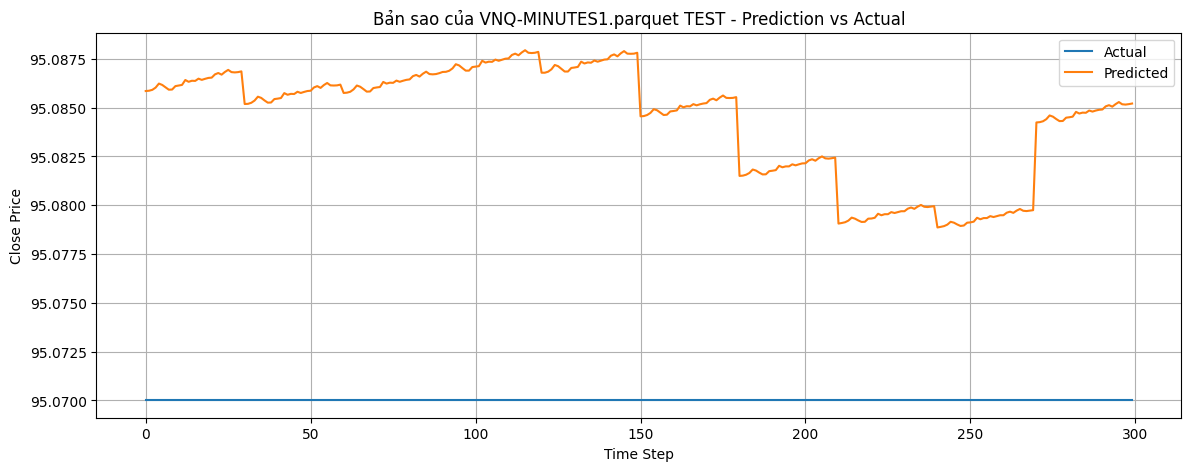


Processing BaÃân sao cuÃâa BIDU-MINUTES1.parquet (25 of 50)


Training BaÃân sao cuÃâa BIDU-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27707/27707 [05:49<00:00, 79.34it/s]


BaÃân sao cuÃâa BIDU-MINUTES1.parquet - Epoch 1 Train Loss: 0.246413
BaÃân sao cuÃâa BIDU-MINUTES1.parquet - Epoch 1 VAL MAE: 0.374579
üìâ Saved loss log to loss_BaÃân sao cuÃâa BIDU-MINUTES1.csv


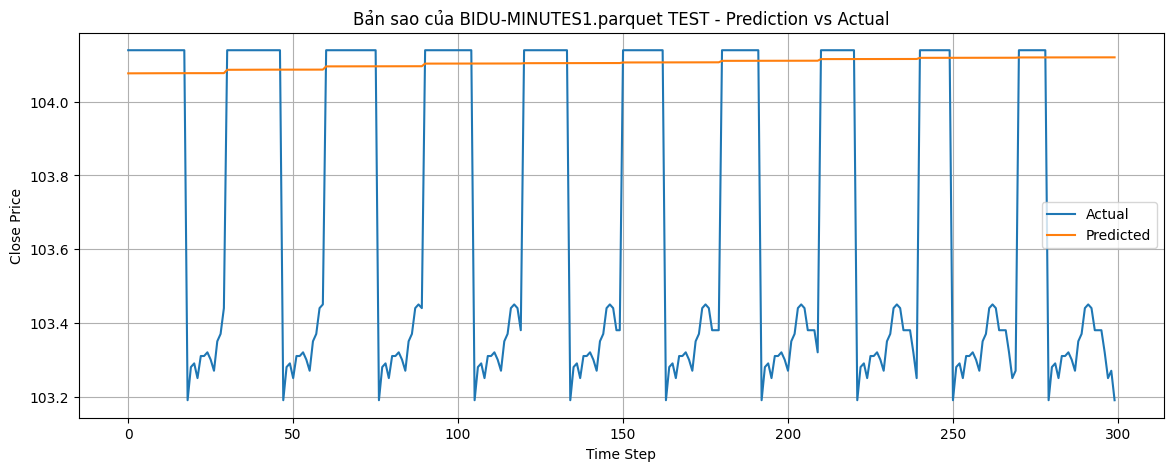


Processing BaÃân sao cuÃâa GM-MINUTES1.parquet (26 of 50)


Training BaÃân sao cuÃâa GM-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24109/24109 [05:04<00:00, 79.09it/s]


BaÃân sao cuÃâa GM-MINUTES1.parquet - Epoch 1 Train Loss: 0.000313
BaÃân sao cuÃâa GM-MINUTES1.parquet - Epoch 1 VAL MAE: 0.067418
üìâ Saved loss log to loss_BaÃân sao cuÃâa GM-MINUTES1.csv



Processing BaÃân sao cuÃâa IBM-MINUTES1.parquet (27 of 50)


Training BaÃân sao cuÃâa IBM-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:52<00:00, 78.61it/s]


BaÃân sao cuÃâa IBM-MINUTES1.parquet - Epoch 1 Train Loss: 0.003790
BaÃân sao cuÃâa IBM-MINUTES1.parquet - Epoch 1 VAL MAE: 0.713228
üìâ Saved loss log to loss_BaÃân sao cuÃâa IBM-MINUTES1.csv



Processing BaÃân sao cuÃâa AXP-MINUTES1.parquet (28 of 50)


Training BaÃân sao cuÃâa AXP-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27454/27454 [05:49<00:00, 78.48it/s]


BaÃân sao cuÃâa AXP-MINUTES1.parquet - Epoch 1 Train Loss: 0.000820
BaÃân sao cuÃâa AXP-MINUTES1.parquet - Epoch 1 VAL MAE: 0.357692
üìâ Saved loss log to loss_BaÃân sao cuÃâa AXP-MINUTES1.csv



Processing BaÃân sao cuÃâa AIG-MINUTES1.parquet (29 of 50)


Training BaÃân sao cuÃâa AIG-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:52<00:00, 78.56it/s]


BaÃân sao cuÃâa AIG-MINUTES1.parquet - Epoch 1 Train Loss: 0.000628
BaÃân sao cuÃâa AIG-MINUTES1.parquet - Epoch 1 VAL MAE: 0.102102
üìâ Saved loss log to loss_BaÃân sao cuÃâa AIG-MINUTES1.csv


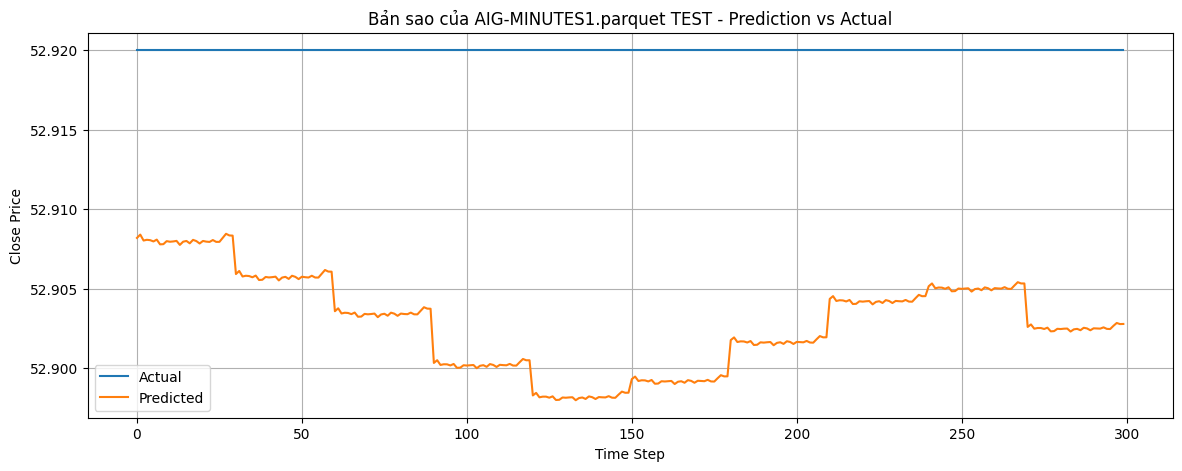


Processing BaÃân sao cuÃâa APC-MINUTES1.parquet (30 of 50)


Training BaÃân sao cuÃâa APC-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24412/24412 [05:13<00:00, 77.77it/s]


BaÃân sao cuÃâa APC-MINUTES1.parquet - Epoch 1 Train Loss: 0.002444
BaÃân sao cuÃâa APC-MINUTES1.parquet - Epoch 1 VAL MAE: 0.620202
üìâ Saved loss log to loss_BaÃân sao cuÃâa APC-MINUTES1.csv


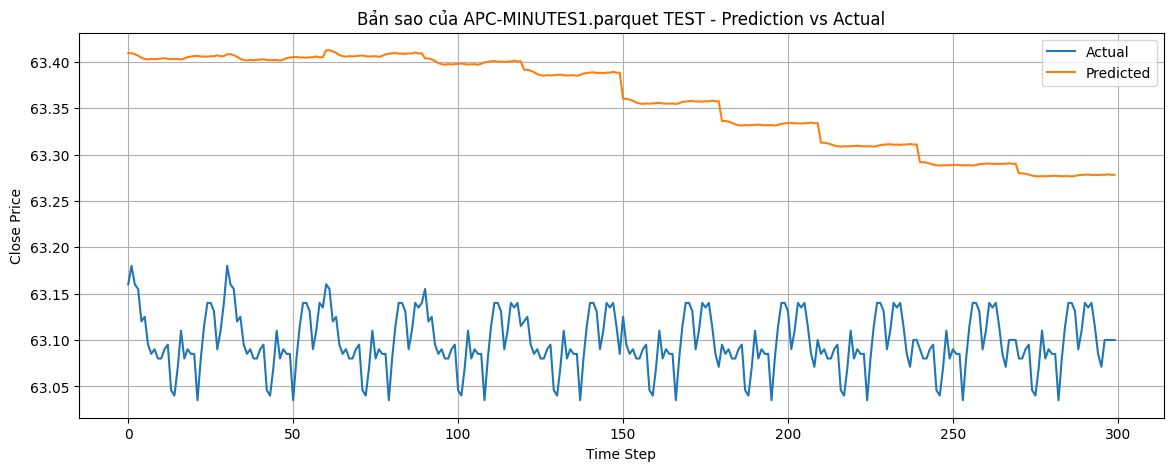


Processing BaÃân sao cuÃâa NVDA-MINUTES1.parquet (31 of 50)


Training BaÃân sao cuÃâa NVDA-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 23827/23827 [05:03<00:00, 78.53it/s]


BaÃân sao cuÃâa NVDA-MINUTES1.parquet - Epoch 1 Train Loss: 0.007242
BaÃân sao cuÃâa NVDA-MINUTES1.parquet - Epoch 1 VAL MAE: 0.830935
üìâ Saved loss log to loss_BaÃân sao cuÃâa NVDA-MINUTES1.csv


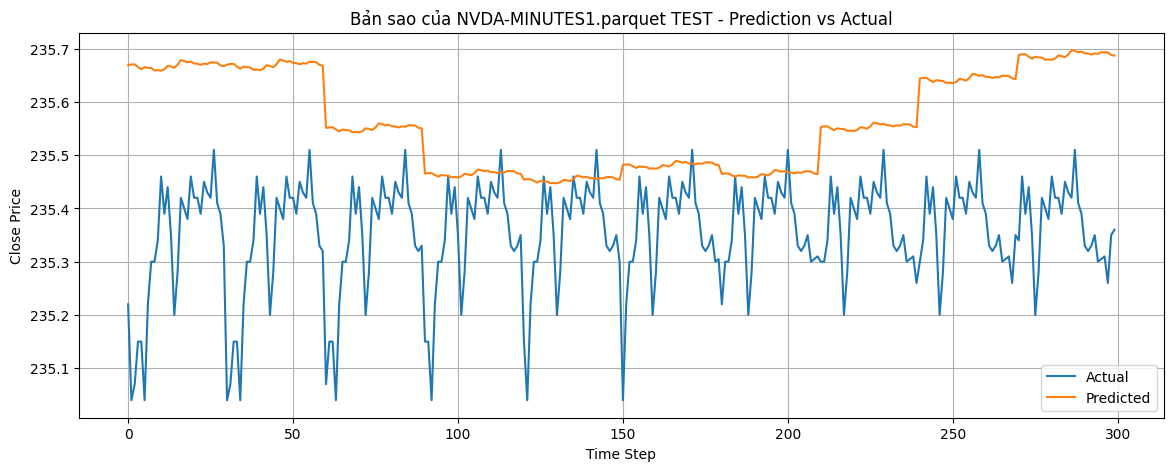


Processing BaÃân sao cuÃâa GS-MINUTES1.parquet (32 of 50)


Training BaÃân sao cuÃâa GS-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27717/27717 [05:49<00:00, 79.21it/s]


BaÃân sao cuÃâa GS-MINUTES1.parquet - Epoch 1 Train Loss: 0.006461
BaÃân sao cuÃâa GS-MINUTES1.parquet - Epoch 1 VAL MAE: 1.615338
üìâ Saved loss log to loss_BaÃân sao cuÃâa GS-MINUTES1.csv


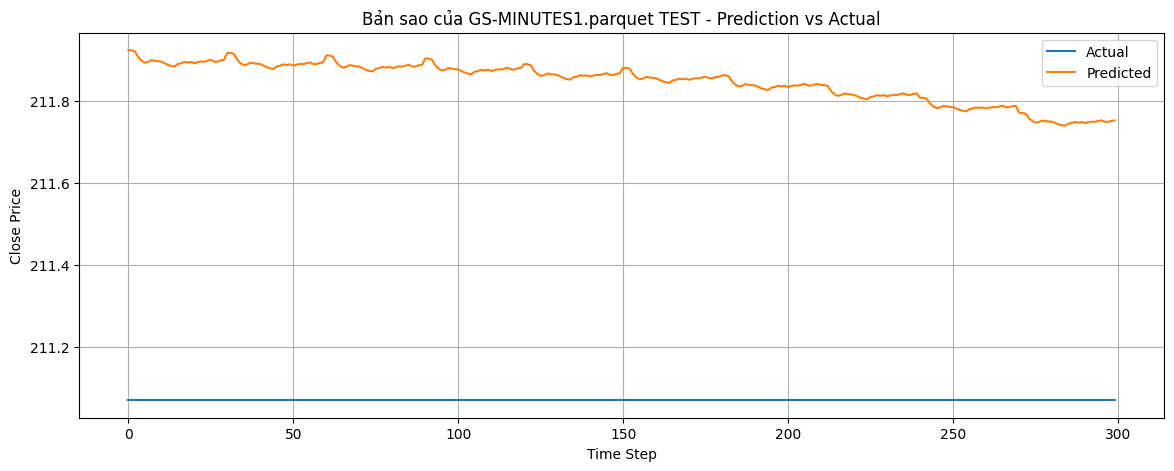


Processing BaÃân sao cuÃâa XOM-MINUTES1.parquet (33 of 50)


Training BaÃân sao cuÃâa XOM-MINUTES1.parquet - Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25873/25873 [05:30<00:00, 78.36it/s]


BaÃân sao cuÃâa XOM-MINUTES1.parquet - Epoch 1 Train Loss: 0.000889
BaÃân sao cuÃâa XOM-MINUTES1.parquet - Epoch 1 VAL MAE: 0.467841
üìâ Saved loss log to loss_BaÃân sao cuÃâa XOM-MINUTES1.csv


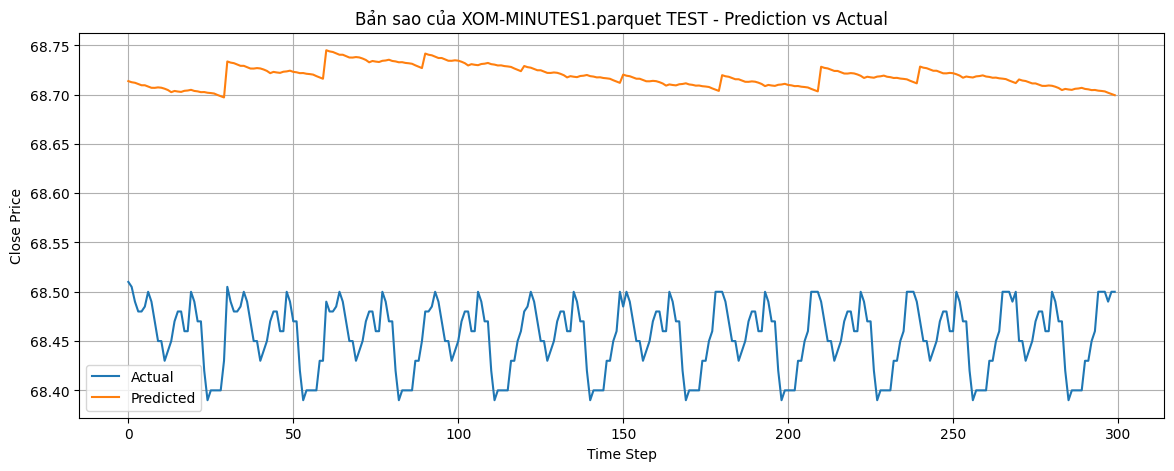


Processing BaÃân sao cuÃâa BMY-MINUTES1.parquet (34 of 50)


Training BaÃân sao cuÃâa BMY-MINUTES1.parquet - Epoch 1:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 23830/27717 [05:04<00:49, 78.21it/s]


KeyboardInterrupt: 

In [3]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from transformers import PatchTSTConfig, PatchTSTForPrediction
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

# ===== Dataset Definition =====
class TimeSeriesDataset(Dataset):
    def __init__(self, series, context_length, prediction_length):
        self.series = series
        self.context_length = context_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.series) - self.context_length - self.prediction_length

    def __getitem__(self, idx):
        x = self.series[idx : idx + self.context_length]
        y = self.series[idx + self.context_length : idx + self.context_length + self.prediction_length]
        return {
            'past_values': torch.tensor(x, dtype=torch.float),
            'future_values': torch.tensor(y, dtype=torch.float),
        }

# ===== Training Function =====
def train_on_single_file(file_path, model, scaler, device, config,
                         context_length=60, prediction_length=30,
                         epochs=1, batch_size=32, best_mae=np.inf):
    try:
        # Load and preprocess data
        df = pd.read_parquet(file_path)
        series = df['close'].dropna().values.reshape(-1, 1)

        # Train/test/val split
        train_size = int(0.8 * len(series))
        val_size = int(0.1 * len(series))
        test_size = len(series) - train_size - val_size

        train_series = series[:train_size]
        val_series = series[train_size:train_size + val_size]
        test_series = series[train_size + val_size:]

        # Fit scaler once
        if not hasattr(scaler, 'mean_'):
            train_scaled = scaler.fit_transform(train_series)
        else:
            train_scaled = scaler.transform(train_series)

        val_scaled = scaler.transform(val_series)
        test_scaled = scaler.transform(test_series)

        # Datasets
        train_dataset = TimeSeriesDataset(train_scaled, context_length, prediction_length)
        val_dataset = TimeSeriesDataset(val_scaled, context_length, prediction_length)
        test_dataset = TimeSeriesDataset(test_scaled, context_length, prediction_length)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
        loss_fn = torch.nn.MSELoss()

        # === Kh·ªüi t·∫°o danh s√°ch ƒë·ªÉ l∆∞u loss ===
        history = {
            'epoch': [],
            'train_loss': [],
            'val_mae': []
        }

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for batch in tqdm(train_loader, desc=f"Training {os.path.basename(file_path)} - Epoch {epoch+1}"):
                x = batch['past_values'].to(device)
                y = batch['future_values'].to(device)

                outputs = model(past_values=x)
                pred = outputs.prediction_outputs
                loss = loss_fn(pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f"{os.path.basename(file_path)} - Epoch {epoch+1} Train Loss: {avg_loss:.6f}")

            val_mae = evaluate_model(model, val_loader, scaler, device, name=f"{os.path.basename(file_path)} VAL", show_plot=False)
            print(f"{os.path.basename(file_path)} - Epoch {epoch+1} VAL MAE: {val_mae:.6f}")

            # === Ghi log ===
            history['epoch'].append(epoch + 1)
            history['train_loss'].append(avg_loss)
            history['val_mae'].append(val_mae)

            # Save best model
            if val_mae < best_mae:
                best_mae = val_mae
                torch.save(model.state_dict(), f"best_model_{os.path.basename(file_path)}.pt")
                print("‚úÖ Saved better model!")

        # === L∆∞u log ra file CSV ===
        loss_df = pd.DataFrame(history)
        loss_file = f"loss_{os.path.splitext(os.path.basename(file_path))[0]}.csv"
        loss_df.to_csv(loss_file, index=False)
        print(f"üìâ Saved loss log to {loss_file}")

        # Final test evaluation
        evaluate_model(model, test_loader, scaler, device, name=f"{os.path.basename(file_path)} TEST")

        return model, best_mae

    except Exception as e:
        print(f"‚ùå Error processing {file_path}: {str(e)}")
        return model, best_mae
    finally:
        del df, series, train_series, val_series, test_series
        gc.collect()

# ===== Evaluation Function =====
def evaluate_model(model, loader, scaler, device, name="Evaluation", show_plot=True):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)
            output = model(past_values=x).prediction_outputs
            preds.append(output.cpu().numpy())
            trues.append(y.cpu().numpy())

    if not preds:
        print(f"No predictions for {name}")
        return np.inf

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_inv = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(trues_inv, preds_inv)

    if show_plot:
        plt.figure(figsize=(14, 5))
        plt.plot(trues_inv[:300], label='Actual')
        plt.plot(preds_inv[:300], label='Predicted')
        plt.title(f'{name} - Prediction vs Actual')
        plt.xlabel('Time Step')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    return mae


# ===== Main Training Loop =====
def main():
    # Configs
    context_length = 60
    prediction_length = 30
    batch_size = 32
    epochs_per_file = 1

    config = PatchTSTConfig(
        context_length=context_length,
        prediction_length=prediction_length,
        patch_len=10,
        stride=10,
        d_model=64,
        num_layers=2,
        num_heads=2,
        dropout=0.3,
        target_dim=1,
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PatchTSTForPrediction(config).to(device)
    scaler = StandardScaler()  # will fit on first file

    data_dir = '/content/drive/MyDrive/Draft/TimeSeries/Duong_Parquet/50Demo'
    processed_files = 0
    best_mae = np.inf

    for file_name in os.listdir(data_dir):
        if file_name.endswith('.parquet'):
            file_path = os.path.join(data_dir, file_name)
            print(f"\nProcessing {file_name} ({processed_files + 1} of {len(os.listdir(data_dir))})")

            model, best_mae = train_on_single_file(
                file_path, model, scaler, device, config,
                context_length, prediction_length,
                epochs_per_file, batch_size, best_mae
            )

            processed_files += 1
            gc.collect()

    torch.save(model.state_dict(), "patchtst_model_final.pt")
    print("‚úÖ Training completed on all files.")


# ===== Entry Point =====
if __name__ == "__main__":
    main()
